# Cohort-Based CLV Forecasting with PyMC-Marketing (KOD Dataset)

This notebook implements a **cohort-based approach** to Customer Lifetime Value (CLV)
forecasting using PyMC-Marketing's BG/NBD and Gamma-Gamma models on the KOD dataset.

## Approach

We fit separate BG/NBD + Gamma-Gamma models **per monthly cohort**, then aggregate
individual-level predictions to monthly cohort revenue for comparison with actuals.
This mirrors the strategy used in the H&M notebook (`hm-pymc-marketing.ipynb`).

## Models

- **BG/NBD (Beta-Geometric/NBD)**: Models customer purchase frequency and dropout
  (continuous time, non-contractual setting)
- **Gamma-Gamma**: Models monetary value of transactions (assumes independence from
  purchase frequency)

## References

- [PyMC-Marketing CLV Quickstart](https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html)
- Fader, P.S., Hardie, B.G.S., & Lee, K.L. (2005). "Counting Your Customers the Easy Way"
- Fader, P.S. & Hardie, B.G.S. (2013). "The Gamma-Gamma Model of Monetary Value"

---
## 1. Setup and Configuration

In [1]:
from __future__ import annotations

import time
from datetime import date
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
from pymc_extras.prior import Prior
from pymc_marketing.clv import BetaGeoModel, GammaGammaModel

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors


In [2]:
# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================

# MAX_COHORT_SIZE: Maximum number of customers per cohort for model fitting.
# - Set to an integer (e.g., 10_000) for faster testing/debugging
# - Set to None to use all customers (production run)
MAX_COHORT_SIZE: int | None = None

SEED: int = sum(map(ord, "kod_clv"))
RNG: np.random.Generator = np.random.default_rng(seed=SEED)

# Date boundaries
DATA_START_DATE = date(2009, 1, 1)
# Training includes all transactions through January 2014
# (matching kod_monthly.ipynb's period <= date(2014, 1, 1))
PERIOD_TRAIN_TEST_SPLIT = date(
    2014, 2, 1
)  # observation_end = first day of first test month
TEST_PERIOD_END = date(2015, 5, 1)  # first day after last complete test month

eps = 1e-6

# =============================================================================
# BG/NBD Model Priors -- Progressive Fallback Strategy
# =============================================================================
# MAP estimation can produce NaN parameters for cohorts with extreme data.
# We use increasingly tight priors as fallbacks:
#
# 1. DEFAULT (sigma=5): moderately informative
# 2. TIGHT (sigma=2/5): first fallback for problematic cohorts
# 3. VERY TIGHT (sigma=1/2): second fallback for very problematic cohorts

BG_NBD_MODEL_CONFIG: dict[str, Prior] = {
    "a": Prior("HalfNormal", sigma=5),
    "b": Prior("HalfNormal", sigma=5),
    "alpha": Prior("HalfNormal", sigma=5),
    "r": Prior("HalfNormal", sigma=5),
}

BG_NBD_MODEL_CONFIG_TIGHT: dict[str, Prior] = {
    "a": Prior("HalfNormal", sigma=2),
    "b": Prior("HalfNormal", sigma=2),
    "alpha": Prior("HalfNormal", sigma=5),
    "r": Prior("HalfNormal", sigma=2),
}

BG_NBD_MODEL_CONFIG_VERY_TIGHT: dict[str, Prior] = {
    "a": Prior("HalfNormal", sigma=1),
    "b": Prior("HalfNormal", sigma=1),
    "alpha": Prior("HalfNormal", sigma=2),
    "r": Prior("HalfNormal", sigma=1),
}

GAMMA_GAMMA_MODEL_CONFIG: dict[str, Prior] = {
    "p": Prior("HalfNormal", sigma=5),
    "q": Prior("HalfNormal", sigma=5),
    "v": Prior("HalfNormal", sigma=50),
}

print(f"MAX_COHORT_SIZE: {MAX_COHORT_SIZE}")
print(f"SEED: {SEED}")
print(f"Train/test split: {PERIOD_TRAIN_TEST_SPLIT}")
print(f"Test end: {TEST_PERIOD_END}")

MAX_COHORT_SIZE: None
SEED: 738
Train/test split: 2014-02-01
Test end: 2015-05-01


---
## 2. Data Loading and Exploration

The KOD dataset contains transaction-level data with columns:
- `customer`: customer identifier
- `date`: transaction date
- `value`: monetary value of the transaction

In [3]:
raw_df = pl.read_csv("../../data/kod.csv", try_parse_dates=True).rename(
    {"customer": "customer_id"}
)

print(f"Shape: {raw_df.shape}")
print(f"Date range: {raw_df['date'].min()} - {raw_df['date'].max()}")
print(f"Unique customers: {raw_df['customer_id'].n_unique():,}")
print("\nValue statistics:")
print(raw_df["value"].describe())
raw_df.head()

Shape: (825573, 3)
Date range: 2009-01-01 - 2015-04-30
Unique customers: 126,843

Value statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 825573.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 18.286009 │
│ std        ┆ 16.690376 │
│ min        ┆ 0.25      │
│ 25%        ┆ 9.45      │
│ 50%        ┆ 15.41     │
│ 75%        ┆ 20.81     │
│ max        ┆ 739.64    │
└────────────┴───────────┘


customer_id,date,value
i64,date,f64
1,2009-01-30,11.75
1,2009-02-02,18.16
1,2009-03-24,19.99
1,2009-04-01,19.99
1,2009-04-27,6.76


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/429910793.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


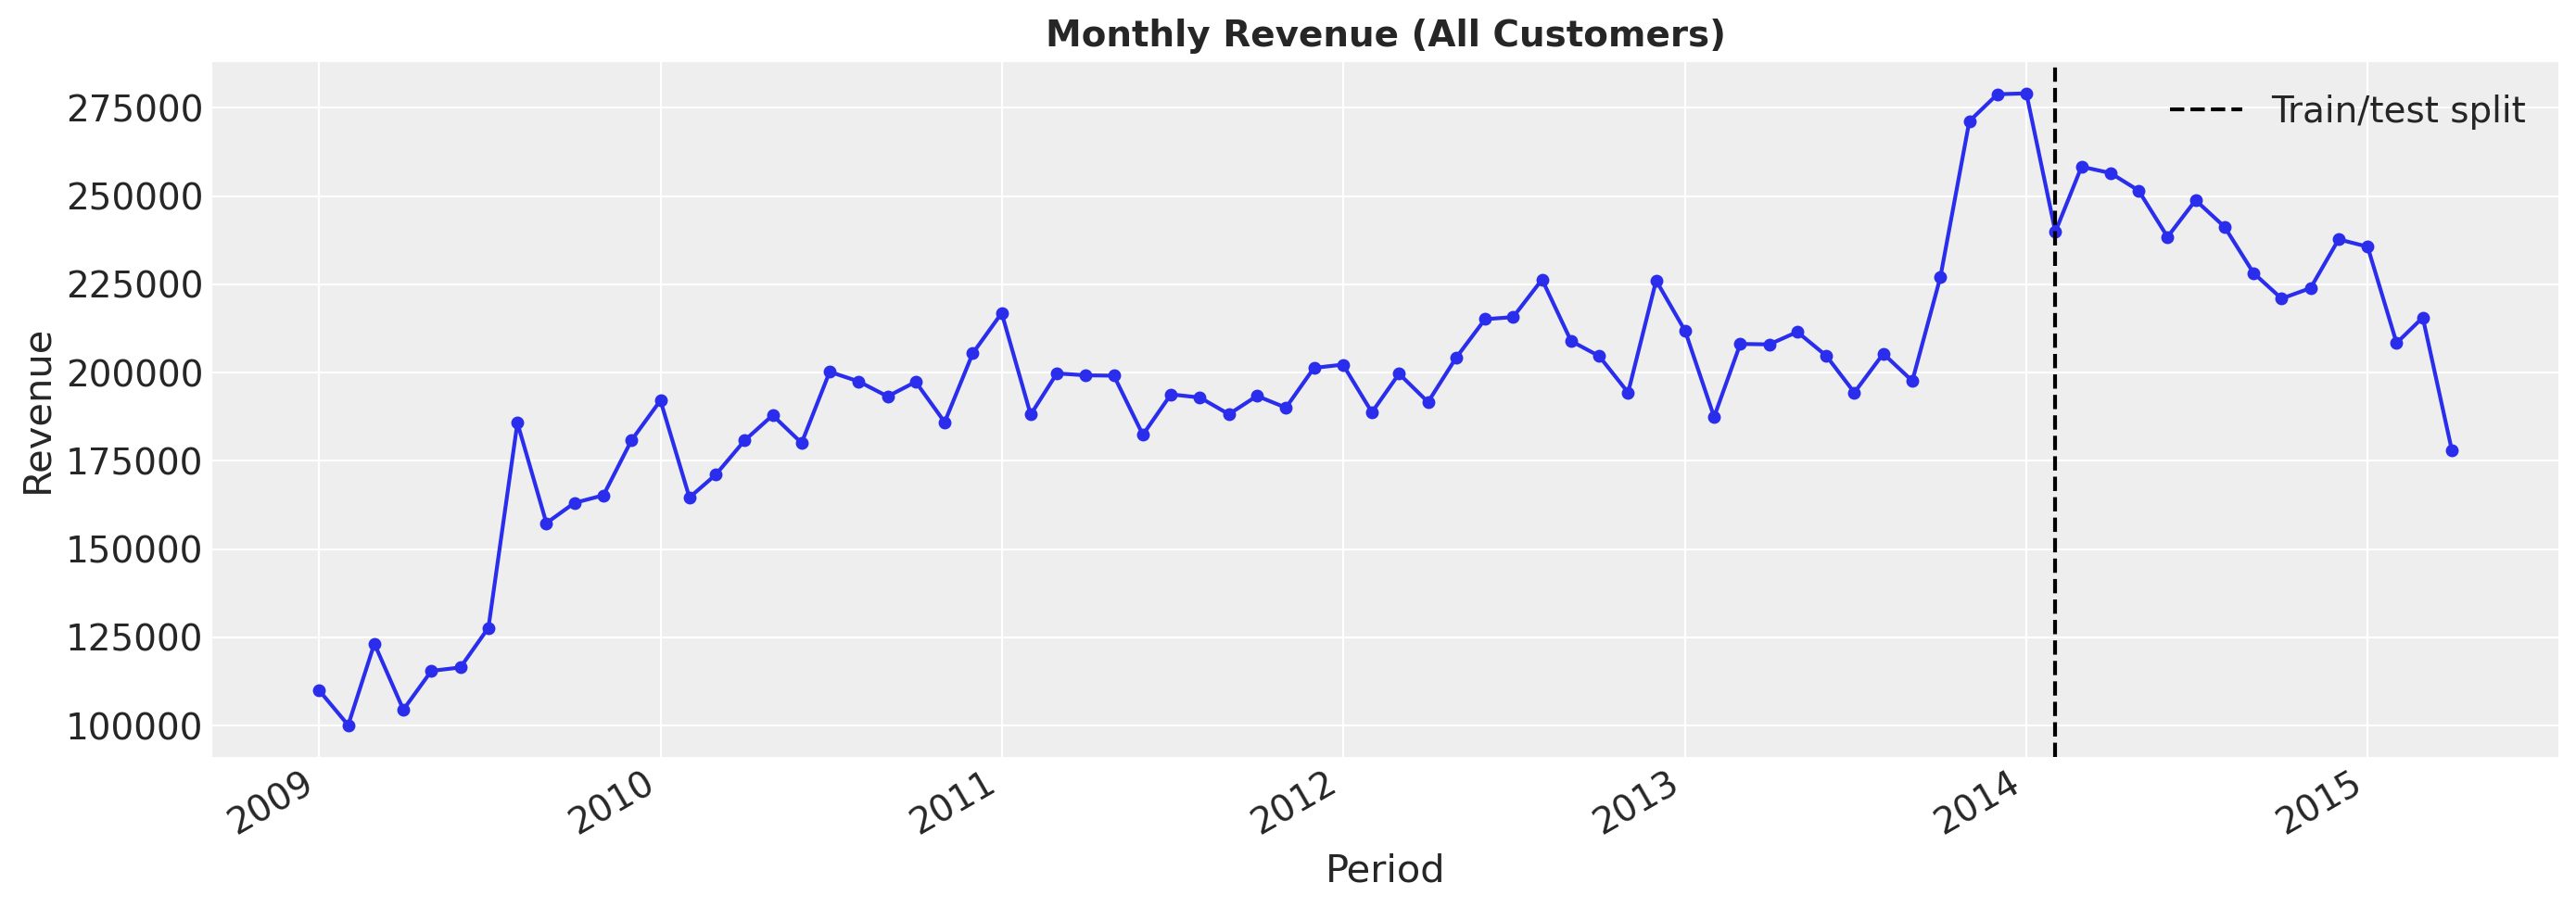

In [4]:
# Aggregate monthly revenue time series
monthly_revenue = (
    raw_df.with_columns(pl.col("date").dt.truncate("1mo").alias("period"))
    .group_by("period")
    .agg(pl.col("value").sum().alias("revenue"))
    .sort("period")
)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(
    monthly_revenue["period"].to_list(),
    monthly_revenue["revenue"].to_list(),
    "o-",
    color="C0",
    markersize=4,
)
ax.axvline(
    PERIOD_TRAIN_TEST_SPLIT,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label="Train/test split",
)
ax.set_xlabel("Period")
ax.set_ylabel("Revenue")
ax.set_title("Monthly Revenue (All Customers)", fontsize=14, fontweight="bold")
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()

---
## 3. Cohort Assignment and Filtering

In [5]:
filtered_df = raw_df.with_columns(
    pl.col("date").dt.truncate("1mo").alias("period"),
).with_columns(
    pl.col("period").min().over("customer_id").alias("cohort"),
)

print(f"Filtered transactions: {filtered_df.height:,}")
print(f"Unique customers: {filtered_df['customer_id'].n_unique():,}")
print(f"Date range: {filtered_df['date'].min()} to {filtered_df['date'].max()}")
print(f"Cohort range: {filtered_df['cohort'].min()} to {filtered_df['cohort'].max()}")
print(f"Number of cohorts: {filtered_df['cohort'].n_unique()}")

Filtered transactions: 825,573
Unique customers: 126,843
Date range: 2009-01-01 to 2015-04-30
Cohort range: 2009-01-01 to 2015-04-01
Number of cohorts: 76


---
## 4. Train/Test Split

Training includes all transactions with `date < 2014-02-01` (all of January 2014
included), matching `kod_monthly.ipynb`'s `period <= date(2014, 1, 1)`.

In [6]:
train_transactions_df = filtered_df.filter(pl.col("date") < PERIOD_TRAIN_TEST_SPLIT)

training_cohorts = train_transactions_df["cohort"].unique().sort().to_list()

print(f"Train transactions: {train_transactions_df.height:,}")
print(f"Train customers: {train_transactions_df['customer_id'].n_unique():,}")
print(f"Training cohorts: {len(training_cohorts)}")
print(f"  First cohort: {training_cohorts[0]}")
print(f"  Last cohort: {training_cohorts[-1]}")

Train transactions: 639,149
Train customers: 108,467
Training cohorts: 61
  First cohort: 2009-01-01
  Last cohort: 2014-01-01


---
## 5. RFM Computation

We compute Recency, Frequency, Monetary value (and T) per customer:

- **frequency** = number of repeat purchases (total transactions - 1)
- **recency** = (last purchase - first purchase) in days
- **T** = (observation_end - first purchase) in days
- **monetary_value** = mean value of **repeat** purchases only (excluding the first
  transaction). This is the correct definition for the Gamma-Gamma model
  (Fader & Hardie 2013), as opposed to `total_spend / n_transactions`.
- **cohort** = first purchase month

In [7]:
def compute_rfm_by_cohort(
    transactions_df: pl.DataFrame,
    observation_end: date,
    time_unit: str = "D",
) -> pl.DataFrame:
    """
    Compute RFM metrics with cohort assignment for all customers.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        Raw transactions with columns: customer_id, date, value, period, cohort
    observation_end : date
        End of observation period for T calculation
    time_unit : str
        Time unit for recency and T: "D" (days) or "W" (weeks)

    Returns
    -------
    pl.DataFrame
        Columns: customer_id, frequency, recency, T, monetary_value, cohort
    """
    divisor = {"D": 1, "W": 7, "M": 30}.get(time_unit, 1)

    return (
        transactions_df.sort("date")
        .group_by("customer_id")
        .agg(
            pl.col("date").min().alias("first_purchase"),
            pl.col("date").max().alias("last_purchase"),
            pl.col("date").count().alias("n_transactions"),
            pl.col("value").sum().alias("total_spend"),
            # Value of the first transaction (for correct monetary_value)
            pl.col("value").sort_by("date").first().alias("first_purchase_value"),
            pl.col("period").min().alias("cohort"),
        )
        .with_columns(
            # frequency = number of repeat purchases (total - 1)
            (pl.col("n_transactions") - 1).alias("frequency"),
            # recency = time between first and last purchase
            (
                (pl.col("last_purchase") - pl.col("first_purchase"))
                .dt.total_days()
                .truediv(divisor)
            ).alias("recency"),
            # T = time between first purchase and observation end
            (
                (pl.lit(observation_end) - pl.col("first_purchase"))
                .dt.total_days()
                .truediv(divisor)
            ).alias("T"),
        )
        .with_columns(
            # monetary_value = mean of REPEAT purchases only (correct Gamma-Gamma definition)  # noqa: E501
            # = (total_spend - first_purchase_value) / frequency
            pl.when(pl.col("frequency") > 0)
            .then(
                (pl.col("total_spend") - pl.col("first_purchase_value"))
                / pl.col("frequency")
            )
            .otherwise(0.0)
            .alias("monetary_value")
        )
        .select(
            "customer_id",
            "frequency",
            "recency",
            "T",
            "monetary_value",
            "cohort",
        )
    )

In [8]:
train_rfm_df = compute_rfm_by_cohort(
    transactions_df=train_transactions_df,
    observation_end=PERIOD_TRAIN_TEST_SPLIT,
    time_unit="D",
)

print(f"RFM data shape: {train_rfm_df.shape}")
print(
    f"Customers with frequency > 0: {train_rfm_df.filter(pl.col('frequency') > 0).height:,}"  # noqa: E501
)
print(
    f"Customers with frequency = 0: {train_rfm_df.filter(pl.col('frequency') == 0).height:,}"  # noqa: E501
)
train_rfm_df.head(10)

RFM data shape: (108467, 6)
Customers with frequency > 0: 65,915
Customers with frequency = 0: 42,552


customer_id,frequency,recency,T,monetary_value,cohort
i64,u32,f64,f64,f64,date
51406,11,1473.0,1640.0,43.017273,2009-08-01
106063,4,333.0,432.0,17.835,2012-11-01
82602,1,19.0,1155.0,19.95,2010-12-01
107754,0,0.0,637.0,0.0,2012-05-01
2245,0,0.0,1724.0,0.0,2009-05-01
58340,2,1165.0,1533.0,11.79,2009-11-01
55723,0,0.0,1575.0,0.0,2009-10-01
108296,9,522.0,644.0,12.244444,2012-04-01
110639,2,21.0,353.0,10.68,2013-02-01


---
## 6. Cohort Summary and Gamma-Gamma Assumption Check

In [9]:
def get_cohort_summary(rfm_df: pl.DataFrame) -> pl.DataFrame:
    """Summarize cohort sizes and repeat customer counts."""
    return (
        rfm_df.group_by("cohort")
        .agg(
            pl.col("customer_id").count().alias("n_customers"),
            (pl.col("frequency") > 0).sum().alias("n_repeat"),
            pl.col("frequency").mean().alias("avg_frequency"),
            pl.col("monetary_value")
            .filter(pl.col("frequency") > 0)
            .mean()
            .alias("avg_monetary"),
        )
        .with_columns(
            (pl.col("n_repeat") / pl.col("n_customers") * 100).alias("pct_repeat")
        )
        .sort("cohort")
    )

In [10]:
cohort_summary = get_cohort_summary(train_rfm_df)
print(f"Number of cohorts: {cohort_summary.height}")
cohort_summary

Number of cohorts: 61


cohort,n_customers,n_repeat,avg_frequency,avg_monetary,pct_repeat
date,u32,u32,f64,f64,f64
2009-01-01,3103,1949,7.664518,17.816785,62.810184
2009-02-01,2394,1542,7.191312,17.546944,64.411028
2009-03-01,2603,1640,6.522474,17.231829,63.004226
2009-04-01,1915,1285,7.525326,17.281815,67.101828
2009-05-01,2186,1398,6.767155,17.032582,63.952425
…,…,…,…,…,…
2013-09-01,1143,568,1.729659,16.498009,49.693788
2013-10-01,1594,778,1.626725,16.848271,48.80803
2013-11-01,1747,836,1.337149,16.748685,47.853463


### Gamma-Gamma Independence Assumption Check

The Gamma-Gamma model assumes that monetary value is independent of purchase frequency
(Fader & Hardie 2013). We check this by computing the Pearson correlation between
`monetary_value` and `frequency` for repeat customers. The rule of thumb is |r| < 0.3.

In [11]:
# Overall correlation check (repeat customers only)
repeat_rfm = train_rfm_df.filter(pl.col("frequency") > 0).to_pandas()
overall_corr = repeat_rfm[["monetary_value", "frequency"]].corr().iloc[0, 1]
print(f"Overall Pearson correlation (monetary_value vs frequency): {overall_corr:.4f}")
print(f"Assumption satisfied (|r| < 0.3): {abs(overall_corr) < 0.3}")

Overall Pearson correlation (monetary_value vs frequency): 0.0795
Assumption satisfied (|r| < 0.3): True


In [12]:
# Per-cohort correlation check
cohort_correlations = []
for cohort_id in sorted(train_rfm_df["cohort"].unique().to_list()):
    cohort_data = train_rfm_df.filter(
        (pl.col("cohort") == cohort_id) & (pl.col("frequency") > 0)
    ).to_pandas()
    if len(cohort_data) > 10:
        corr = cohort_data[["monetary_value", "frequency"]].corr().iloc[0, 1]
        cohort_correlations.append(
            {"cohort": cohort_id, "correlation": corr, "n_repeat": len(cohort_data)}
        )

corr_df = pl.DataFrame(cohort_correlations)
n_flagged = corr_df.filter(pl.col("correlation").abs() > 0.3).height
print(f"\nCohorts with |correlation| > 0.3: {n_flagged}/{corr_df.height}")
if n_flagged > 0:
    print("Flagged cohorts:")
    print(corr_df.filter(pl.col("correlation").abs() > 0.3))


Cohorts with |correlation| > 0.3: 0/61


---
## 7. Model Fitting Helper Functions

In [13]:
def subsample_cohort_if_needed(
    rfm_data: pl.DataFrame,
    max_size: int | None,
    random_seed: int = SEED,
) -> tuple[pl.DataFrame, int, bool]:
    """
    Subsample cohort data if it exceeds max_size (without replacement).

    Parameters
    ----------
    rfm_data : pl.DataFrame
        RFM data for a single cohort
    max_size : int | None
        Maximum cohort size. If None, no subsampling.
    random_seed : int
        Random seed for reproducible subsampling

    Returns
    -------
    tuple[pl.DataFrame, int, bool]
        (subsampled_data, original_size, was_subsampled)
    """
    original_size = rfm_data.height

    if max_size is None:
        return rfm_data, original_size, False

    if rfm_data.height <= max_size:
        return rfm_data, original_size, False

    subsampled = rfm_data.sample(n=max_size, seed=random_seed, with_replacement=False)
    return subsampled, original_size, True

In [14]:
def validate_cohort_data(
    rfm_pd: pd.DataFrame,
    min_customers: int = 50,
    min_repeat_customers: int = 10,
) -> bool:
    """Validate cohort data meets minimum requirements for stable MAP fitting."""
    n_customers = len(rfm_pd)
    n_repeat = (rfm_pd["frequency"] > 0).sum()
    return n_customers >= min_customers and n_repeat >= min_repeat_customers

In [15]:
def validate_fit_result(model) -> bool:
    """Check if model fit produced valid (non-NaN/Inf) parameter estimates."""
    try:
        fit_result = model.fit_result
        for var_name in fit_result.data_vars:
            values = fit_result[var_name].to_numpy()
            if np.any(np.isnan(values)) or np.any(np.isinf(values)):
                return False
        return True
    except Exception:
        return False

In [16]:
def fit_single_cohort(  # noqa: C901
    cohort_id: date,
    rfm_data: pl.DataFrame,
    fit_method: str = "map",
    sampler_kwargs: dict[str, Any] | None = None,
    max_cohort_size: int | None = MAX_COHORT_SIZE,
    min_customers: int = 50,
    min_repeat_customers: int = 10,
    model_config: dict[str, Prior] | None = None,
    max_retries: int = 10,
    *,
    verbose: bool = True,
) -> dict[str, Any]:
    """
    Fit BG/NBD and Gamma-Gamma models for a single cohort.

    Uses a progressive prior fallback strategy: default -> tight -> very tight.

    Returns
    -------
    dict
        Keys: 'cohort_id', 'bgm', 'ggm', 'rfm_data', 'rfm_pd', 'n_customers',
              'n_repeat', 'original_size', 'was_subsampled', 'fit_time', 'success'
    """
    start_time = time.time()

    # Subsample if needed
    rfm_subsampled, original_size, was_subsampled = subsample_cohort_if_needed(
        rfm_data, max_cohort_size
    )

    # Convert to pandas for PyMC-Marketing
    rfm_pd = rfm_subsampled.to_pandas()
    rfm_pd["monetary_value"] = rfm_pd["monetary_value"].clip(lower=eps)

    n_customers = len(rfm_pd)
    n_repeat = int((rfm_pd["frequency"] > 0).sum())

    if verbose and was_subsampled:
        print(f"    Subsampled from {original_size:,} to {n_customers:,}")

    # Pre-fit data validation
    if not validate_cohort_data(rfm_pd, min_customers, min_repeat_customers):
        fit_time = time.time() - start_time
        return {
            "cohort_id": cohort_id,
            "bgm": None,
            "ggm": None,
            "rfm_data": rfm_subsampled,
            "rfm_pd": rfm_pd,
            "n_customers": n_customers,
            "n_repeat": n_repeat,
            "original_size": original_size,
            "was_subsampled": was_subsampled,
            "fit_time": fit_time,
            "success": False,
        }

    bgm_config = model_config if model_config is not None else BG_NBD_MODEL_CONFIG

    # --- Fit BG/NBD with progressive prior fallback ---
    bgm = None

    # Try default priors
    for attempt in range(max_retries):
        try:
            bgm = BetaGeoModel(data=rfm_pd, model_config=bgm_config)
            fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
            if fit_method == "map":
                fit_kwargs.setdefault("maxeval", 5000)
                fit_kwargs.setdefault("progressbar", False)
                fit_kwargs["seed"] = (
                    SEED + attempt * 1000 + hash(str(cohort_id)) % 10000
                )
            bgm.fit(method=fit_method, **fit_kwargs)
            if validate_fit_result(bgm):
                break
            bgm = None
        except Exception:
            bgm = None
            continue

    # Fallback 1: tight priors
    if bgm is None and model_config is None:
        for attempt in range(max_retries):
            try:
                bgm = BetaGeoModel(data=rfm_pd, model_config=BG_NBD_MODEL_CONFIG_TIGHT)
                fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
                if fit_method == "map":
                    fit_kwargs.setdefault("maxeval", 5000)
                    fit_kwargs.setdefault("progressbar", False)
                    fit_kwargs["seed"] = (
                        SEED + attempt * 1000 + hash(str(cohort_id)) % 10000 + 100
                    )
                bgm.fit(method=fit_method, **fit_kwargs)
                if validate_fit_result(bgm):
                    break
                bgm = None
            except Exception:
                bgm = None
                continue

    # Fallback 2: very tight priors
    if bgm is None and model_config is None:
        for attempt in range(max_retries):
            try:
                bgm = BetaGeoModel(
                    data=rfm_pd, model_config=BG_NBD_MODEL_CONFIG_VERY_TIGHT
                )
                fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
                if fit_method == "map":
                    fit_kwargs.setdefault("maxeval", 5000)
                    fit_kwargs.setdefault("progressbar", False)
                    fit_kwargs["seed"] = (
                        SEED + attempt * 1000 + hash(str(cohort_id)) % 10000 + 200
                    )
                bgm.fit(method=fit_method, **fit_kwargs)
                if validate_fit_result(bgm):
                    break
                bgm = None
            except Exception:
                bgm = None
                continue

    # If BG/NBD failed, return early
    if bgm is None:
        fit_time = time.time() - start_time
        return {
            "cohort_id": cohort_id,
            "bgm": None,
            "ggm": None,
            "rfm_data": rfm_subsampled,
            "rfm_pd": rfm_pd,
            "n_customers": n_customers,
            "n_repeat": n_repeat,
            "original_size": original_size,
            "was_subsampled": was_subsampled,
            "fit_time": fit_time,
            "success": False,
        }

    # --- Fit Gamma-Gamma (repeat customers only) ---
    ggm = None
    repeat_data = rfm_pd[rfm_pd["frequency"] > 0].copy()
    if len(repeat_data) >= min_repeat_customers:
        repeat_data["monetary_value"] = repeat_data["monetary_value"].clip(lower=eps)
        for attempt in range(max_retries):
            try:
                ggm = GammaGammaModel(
                    data=repeat_data, model_config=GAMMA_GAMMA_MODEL_CONFIG
                )
                fit_kwargs = sampler_kwargs.copy() if sampler_kwargs else {}
                if fit_method == "map":
                    fit_kwargs.setdefault("maxeval", 5000)
                    fit_kwargs.setdefault("progressbar", False)
                    fit_kwargs["seed"] = (
                        SEED + attempt * 1000 + hash(str(cohort_id)) % 10000 + 500
                    )
                ggm.fit(method=fit_method, **fit_kwargs)
                if validate_fit_result(ggm):
                    break
                ggm = None
            except Exception:
                ggm = None
                continue

    fit_time = time.time() - start_time
    success = bgm is not None and ggm is not None

    return {
        "cohort_id": cohort_id,
        "bgm": bgm,
        "ggm": ggm,
        "rfm_data": rfm_subsampled,
        "rfm_pd": rfm_pd,
        "n_customers": n_customers,
        "n_repeat": n_repeat,
        "original_size": original_size,
        "was_subsampled": was_subsampled,
        "fit_time": fit_time,
        "success": success,
    }

In [17]:
def fit_all_cohorts(
    rfm_df: pl.DataFrame,
    fit_method: str = "map",
    sampler_kwargs: dict[str, Any] | None = None,
    max_cohort_size: int | None = MAX_COHORT_SIZE,
    min_customers: int = 50,
    min_repeat_customers: int = 10,
    model_config: dict[str, Prior] | None = None,
    max_retries: int = 10,
    *,
    verbose: bool = True,
) -> dict[date, dict[str, Any]]:
    """
    Fit BG/NBD and Gamma-Gamma models for all cohorts sequentially.

    Only returns successful fits (failed cohorts are excluded from results).
    """
    cohorts = sorted(rfm_df["cohort"].unique().to_list())
    n_cohorts = len(cohorts)

    if verbose:
        print(f"Fitting {n_cohorts} cohorts...")
        if max_cohort_size is not None:
            print(f"MAX_COHORT_SIZE = {max_cohort_size:,}")
        print("-" * 60)

    cohort_results = {}
    total_start = time.time()
    n_success = 0

    for i, cohort_id in enumerate(cohorts, 1):
        cohort_rfm = rfm_df.filter(pl.col("cohort") == cohort_id)

        if verbose:
            n = cohort_rfm.height
            print(f"[{i}/{n_cohorts}] Cohort {cohort_id}: {n:,} customers...", end=" ")

        result = fit_single_cohort(
            cohort_id=cohort_id,
            rfm_data=cohort_rfm,
            fit_method=fit_method,
            sampler_kwargs=sampler_kwargs,
            max_cohort_size=max_cohort_size,
            min_customers=min_customers,
            min_repeat_customers=min_repeat_customers,
            model_config=model_config,
            max_retries=max_retries,
            verbose=False,
        )

        if result["success"]:
            cohort_results[cohort_id] = result
            n_success += 1

        if verbose:
            subsample_info = (
                f" (subsampled from {result['original_size']:,})"
                if result["was_subsampled"]
                else ""
            )
            n_cust = result["n_customers"]
            n_rep = result["n_repeat"]
            t = result["fit_time"]
            status = "OK" if result["success"] else "SKIPPED"
            msg = f"{status} in {t:.1f}s - {n_cust:,} cust{subsample_info}, {n_rep:,} repeat"  # noqa: E501
            print(msg)

    total_time = time.time() - total_start

    if verbose:
        print("-" * 60)
        print(f"Total fitting time: {total_time:.1f}s ({total_time / 60:.1f} min)")
        print(f"Successful cohorts: {n_success}/{n_cohorts}")

    return cohort_results

---
## 8. Model Fitting Execution and Diagnostics

In [18]:
%%time

print(f"Starting model fitting with MAX_COHORT_SIZE = {MAX_COHORT_SIZE}")
print("=" * 60)

cohort_results = fit_all_cohorts(
    rfm_df=train_rfm_df,
    fit_method="map",
    max_cohort_size=MAX_COHORT_SIZE,
    verbose=True,
)

print("=" * 60)
print(f"Fitted {len(cohort_results)} cohort models")

Starting model fitting with MAX_COHORT_SIZE = None
Fitting 61 cohorts...
------------------------------------------------------------
[1/61] Cohort 2009-01-01: 3,103 customers... OK in 19.4s - 3,103 cust, 1,949 repeat
[2/61] Cohort 2009-02-01: 2,394 customers... OK in 11.0s - 2,394 cust, 1,542 repeat
[3/61] Cohort 2009-03-01: 2,603 customers... OK in 9.6s - 2,603 cust, 1,640 repeat
[4/61] Cohort 2009-04-01: 1,915 customers... OK in 12.5s - 1,915 cust, 1,285 repeat
[5/61] Cohort 2009-05-01: 2,186 customers... OK in 10.9s - 2,186 cust, 1,398 repeat
[6/61] Cohort 2009-06-01: 2,078 customers... OK in 11.1s - 2,078 cust, 1,353 repeat
[7/61] Cohort 2009-07-01: 1,888 customers... OK in 9.6s - 1,888 cust, 1,390 repeat
[8/61] Cohort 2009-08-01: 2,785 customers... OK in 12.4s - 2,785 cust, 1,873 repeat
[9/61] Cohort 2009-09-01: 2,096 customers... OK in 10.9s - 2,096 cust, 1,385 repeat
[10/61] Cohort 2009-10-01: 2,240 customers... OK in 9.9s - 2,240 cust, 1,464 repeat
[11/61] Cohort 2009-11-01: 2

In [19]:
# Summary of fitted models
print("\nFitted Model Summary:")
print("-" * 80)
header = (
    f"{'Cohort':<12} {'Customers':>10} {'Repeat':>10} {'Subsampled':>12} {'Time':>8}"
)
print(header)
print("-" * 80)

for cohort_id, result in sorted(cohort_results.items()):
    sub = "Yes" if result["was_subsampled"] else "No"
    print(
        f"{cohort_id.strftime('%Y-%m'):<12} "
        f"{result['n_customers']:>10,} "
        f"{result['n_repeat']:>10,} "
        f"{sub:>12} "
        f"{result['fit_time']:>8.1f}s"
    )


Fitted Model Summary:
--------------------------------------------------------------------------------
Cohort        Customers     Repeat   Subsampled     Time
--------------------------------------------------------------------------------
2009-01           3,103      1,949           No     19.4s
2009-02           2,394      1,542           No     11.0s
2009-03           2,603      1,640           No      9.6s
2009-04           1,915      1,285           No     12.5s
2009-05           2,186      1,398           No     10.9s
2009-06           2,078      1,353           No     11.1s
2009-07           1,888      1,390           No      9.6s
2009-08           2,785      1,873           No     12.4s
2009-09           2,096      1,385           No     10.9s
2009-10           2,240      1,464           No      9.9s
2009-11           2,075      1,323           No     12.2s
2009-12           2,165      1,420           No     10.9s
2010-01           2,363      1,546           No      9.6s
2010

In [20]:
# BG/NBD parameters for first few cohorts
print("BG/NBD Model Parameters by Cohort:")
print("-" * 60)

for cohort_id in list(cohort_results.keys())[:5]:
    result = cohort_results[cohort_id]
    bgm = result["bgm"]
    print(f"\nCohort {cohort_id.strftime('%Y-%m')}:")
    print(bgm.fit_summary())

BG/NBD Model Parameters by Cohort:
------------------------------------------------------------

Cohort 2009-01:
a         0.562
alpha    10.051
b         2.149
r         0.205
Name: value, dtype: float64

Cohort 2009-02:
a        0.648
alpha    9.012
b        2.428
r        0.209
Name: value, dtype: float64

Cohort 2009-03:
a        0.616
alpha    8.309
b        2.068
r        0.196
Name: value, dtype: float64

Cohort 2009-04:
a         0.655
alpha    10.212
b         2.530
r         0.231
Name: value, dtype: float64

Cohort 2009-05:
a         0.626
alpha    11.169
b         2.590
r         0.215
Name: value, dtype: float64


In [21]:
# Gamma-Gamma parameters for first few cohorts
print("Gamma-Gamma Model Parameters by Cohort:")
print("-" * 60)

for cohort_id in list(cohort_results.keys())[:5]:
    result = cohort_results[cohort_id]
    ggm = result["ggm"]
    if ggm is not None:
        print(f"\nCohort {cohort_id.strftime('%Y-%m')}:")
        print(ggm.fit_summary())

Gamma-Gamma Model Parameters by Cohort:
------------------------------------------------------------

Cohort 2009-01:
p     2.512
q    10.528
v    68.220
Name: value, dtype: float64

Cohort 2009-02:
p     3.071
q    10.786
v    56.521
Name: value, dtype: float64

Cohort 2009-03:
p     2.553
q     8.367
v    50.729
Name: value, dtype: float64

Cohort 2009-04:
p     2.922
q     9.031
v    48.375
Name: value, dtype: float64

Cohort 2009-05:
p     2.679
q     9.573
v    55.377
Name: value, dtype: float64


In [22]:
def plot_cohort_parameter_comparison(
    cohort_results: dict[date, dict[str, Any]],
    param_name: str = "alpha",
    model_type: str = "bgm",
) -> plt.Figure:
    """Plot parameter values across cohorts."""
    cohorts = []
    values = []

    for cohort_id, result in sorted(cohort_results.items()):
        model = result[model_type]
        if model is not None:
            try:
                fit_result = model.fit_result
                if param_name in fit_result:
                    val = float(fit_result[param_name].to_numpy().mean())
                    cohorts.append(cohort_id)
                    values.append(val)
            except Exception:
                pass

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.bar(range(len(cohorts)), values, color="steelblue", edgecolor="black")
    ax.set_xticks(range(len(cohorts)))
    ax.set_xticklabels(
        [d.strftime("%Y-%m") for d in cohorts], rotation=45, ha="right", fontsize=7
    )
    ax.set_xlabel("Cohort")
    ax.set_ylabel(param_name)
    ax.set_title(
        f"{model_type.upper()} Parameter '{param_name}' by Cohort",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    return fig

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/2776794594.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


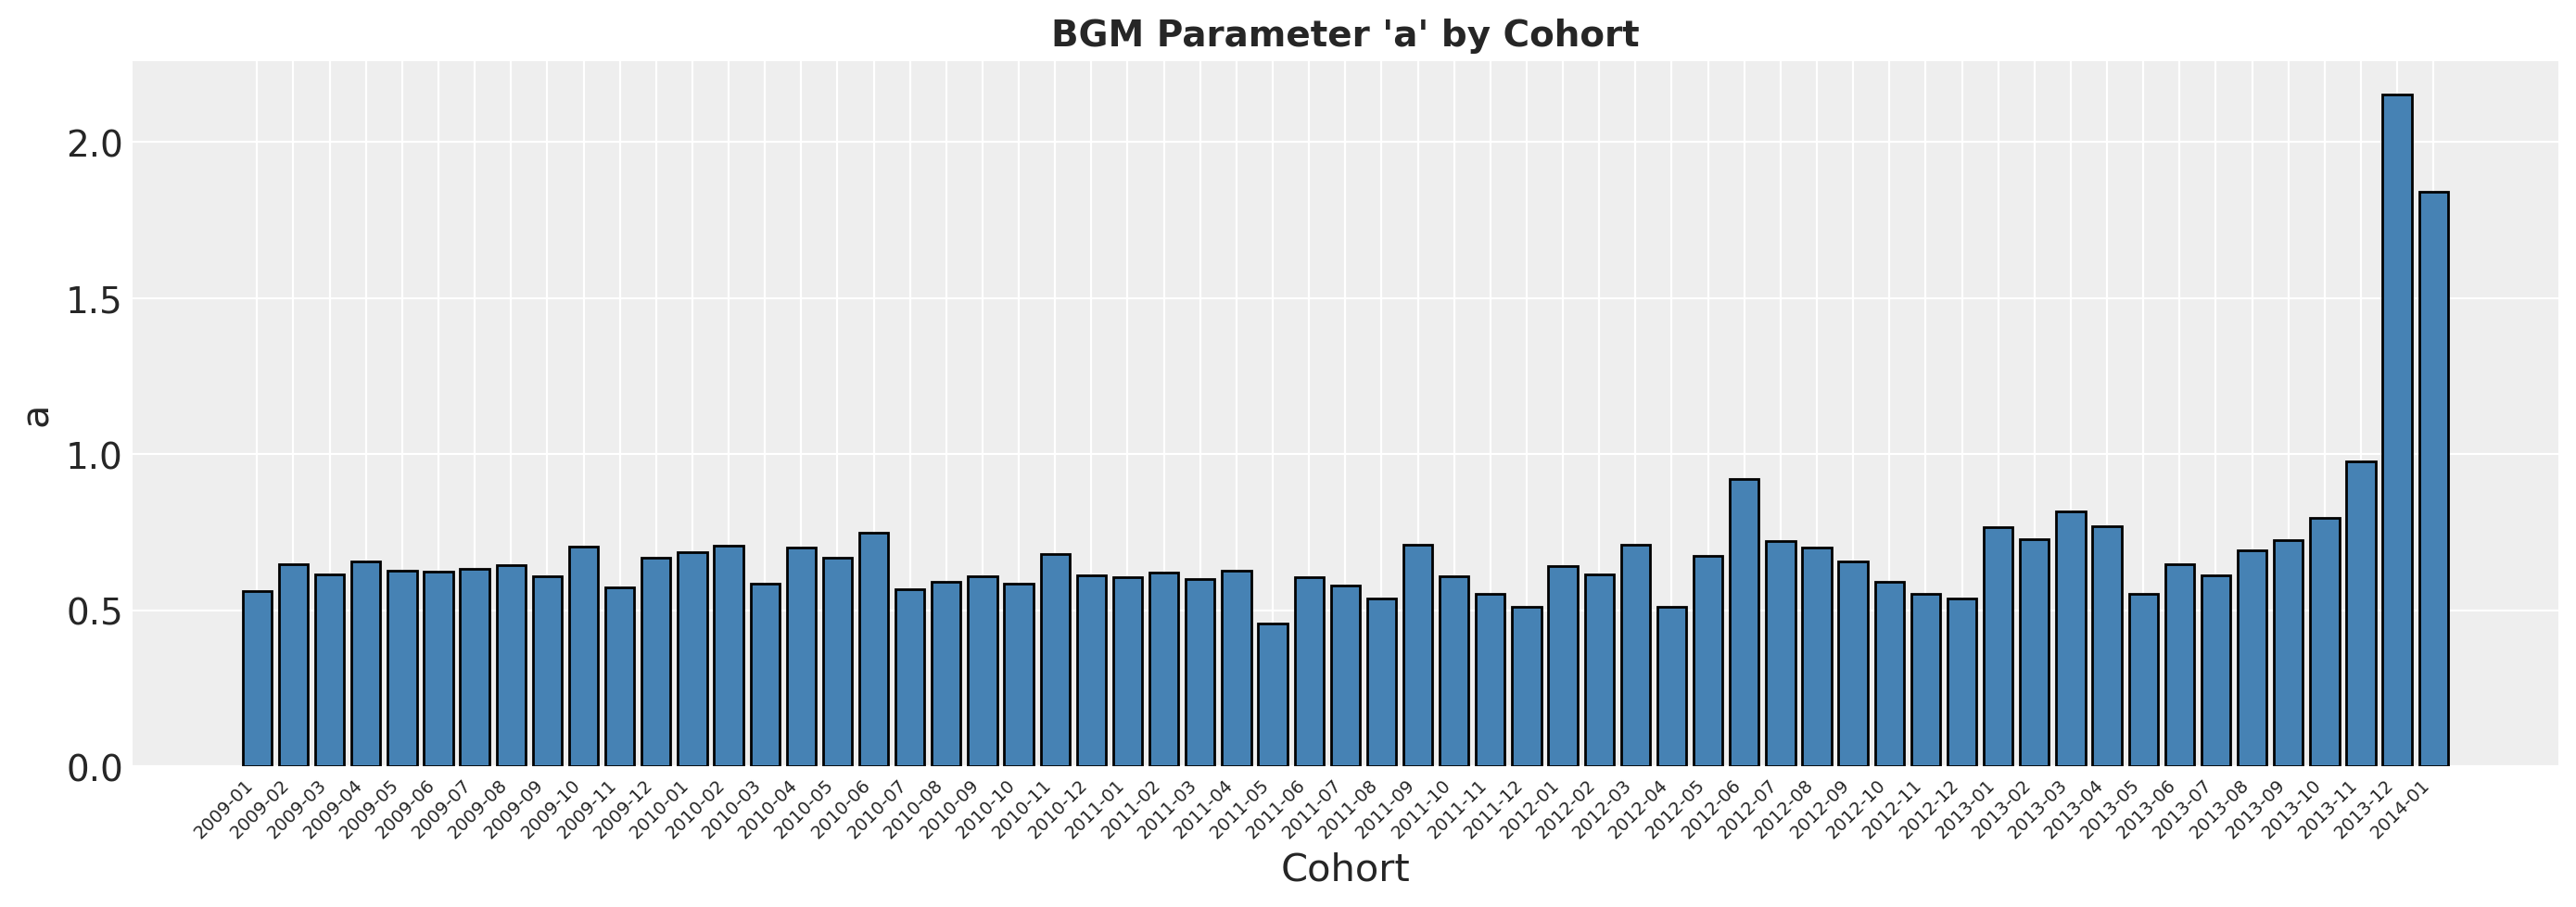

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/2776794594.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


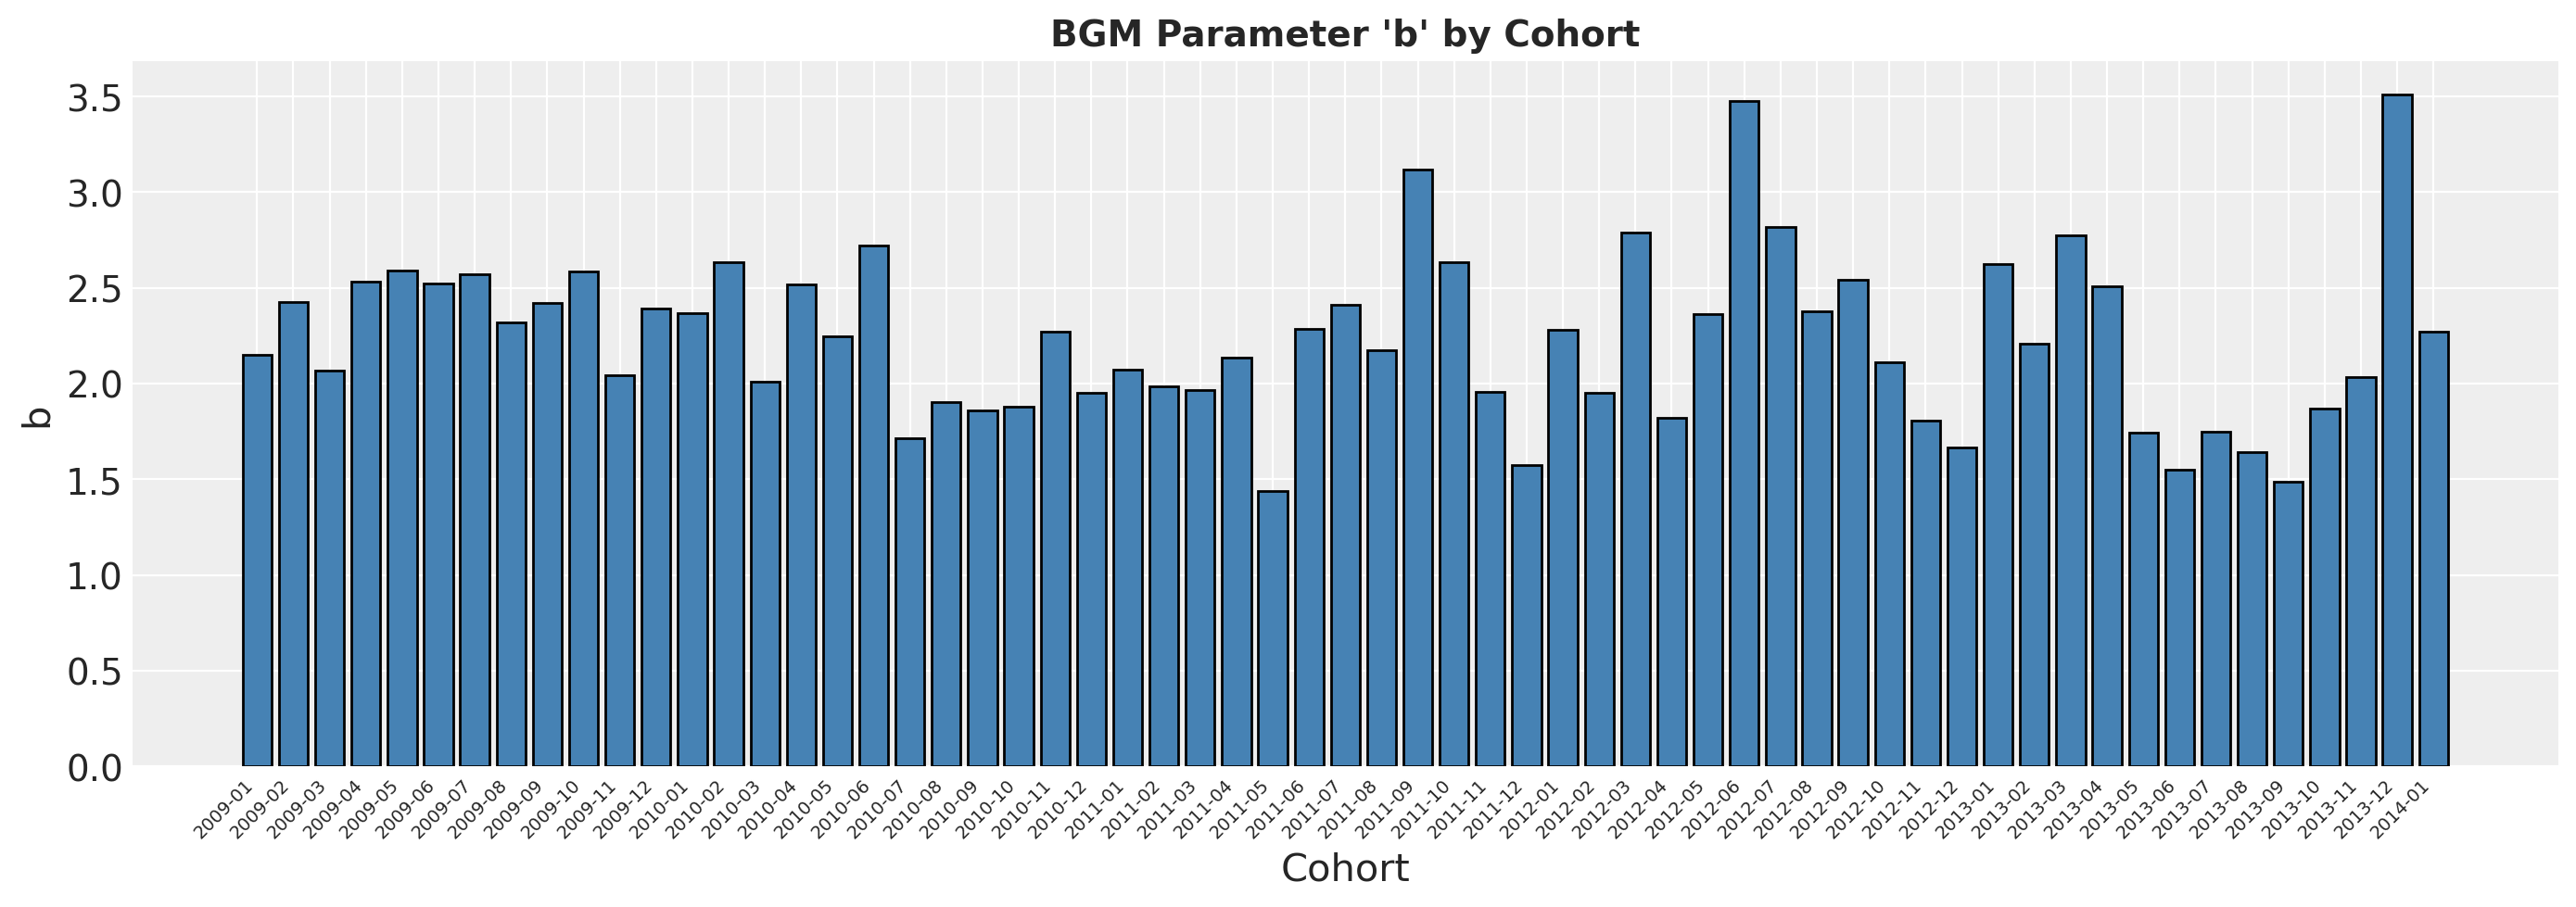

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/2776794594.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


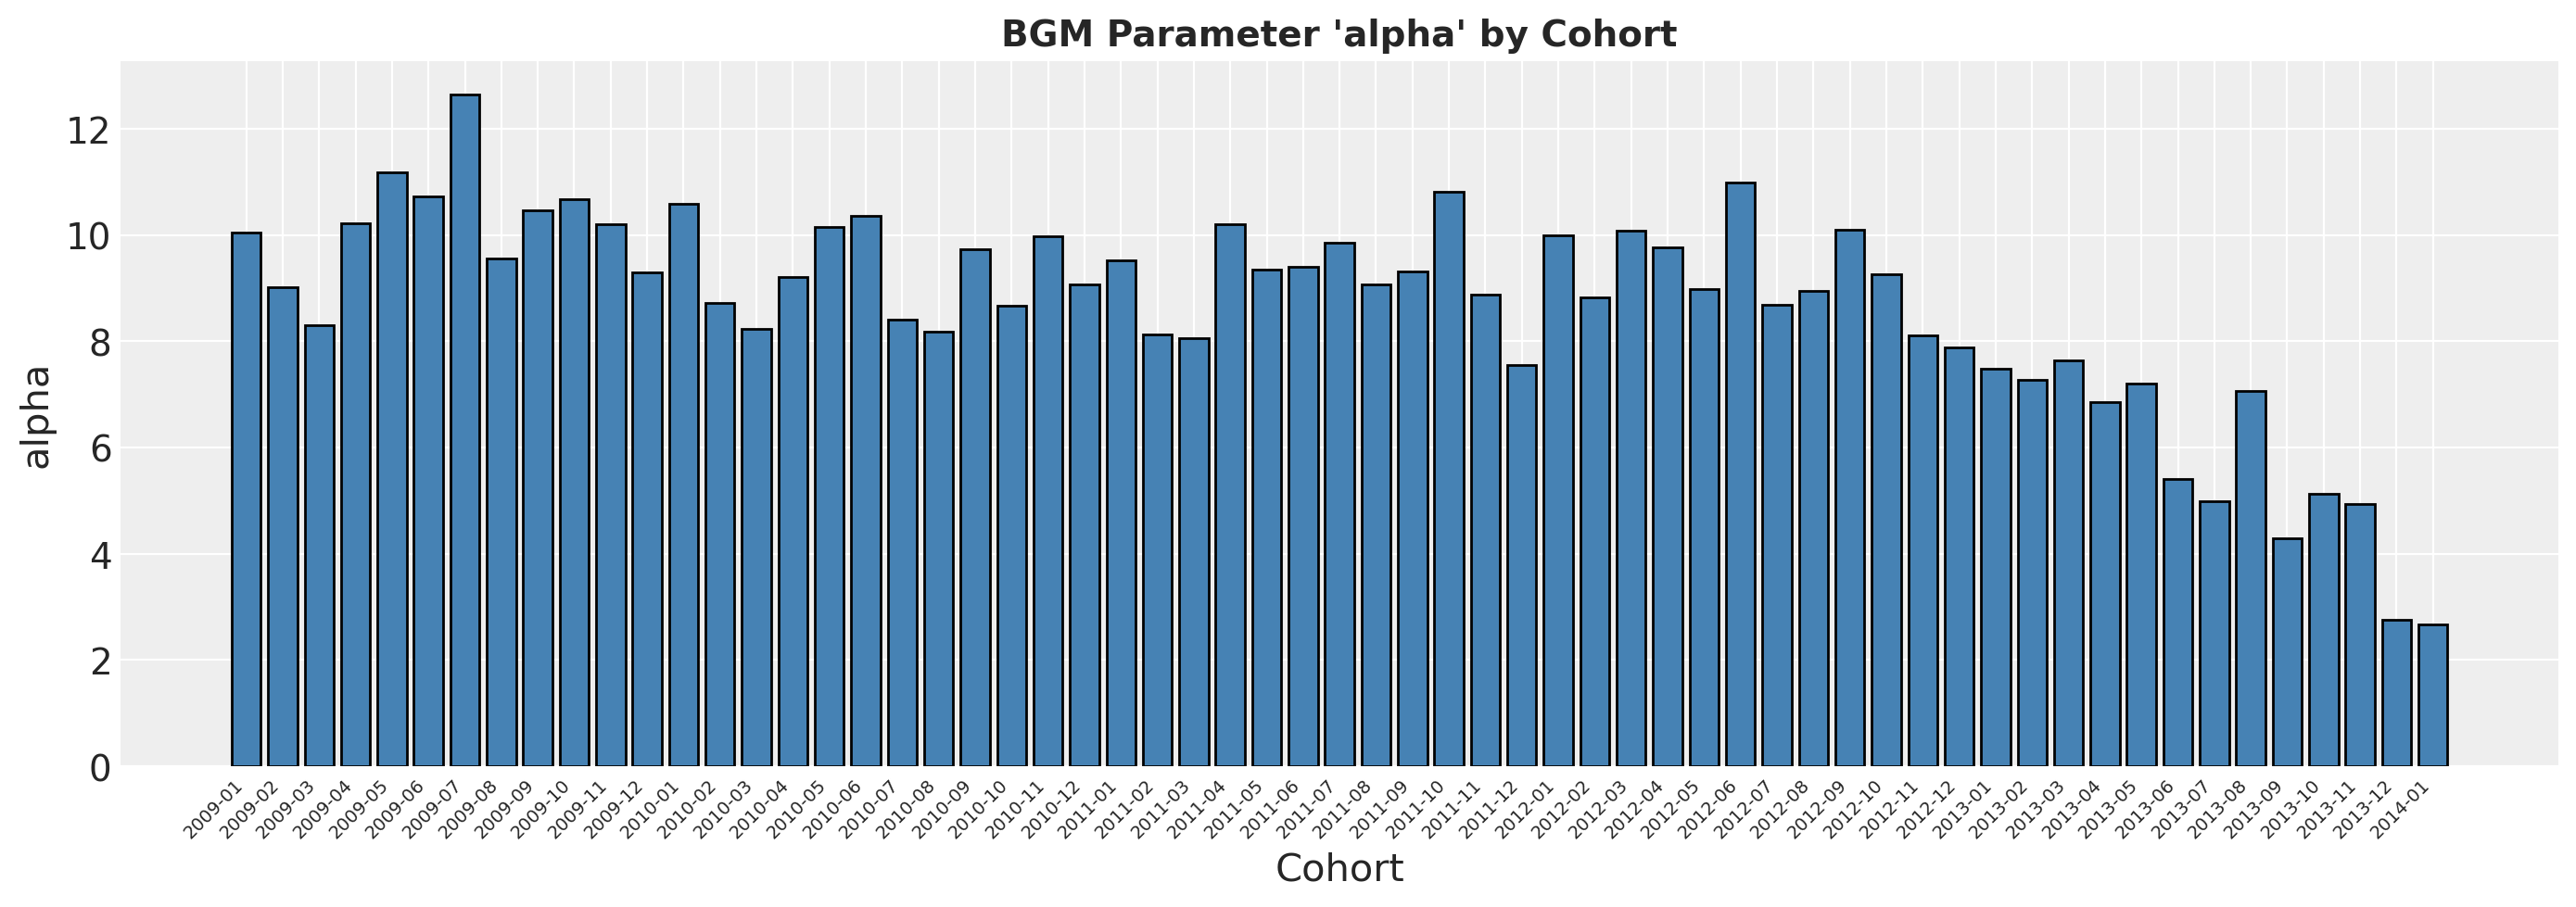

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/2776794594.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


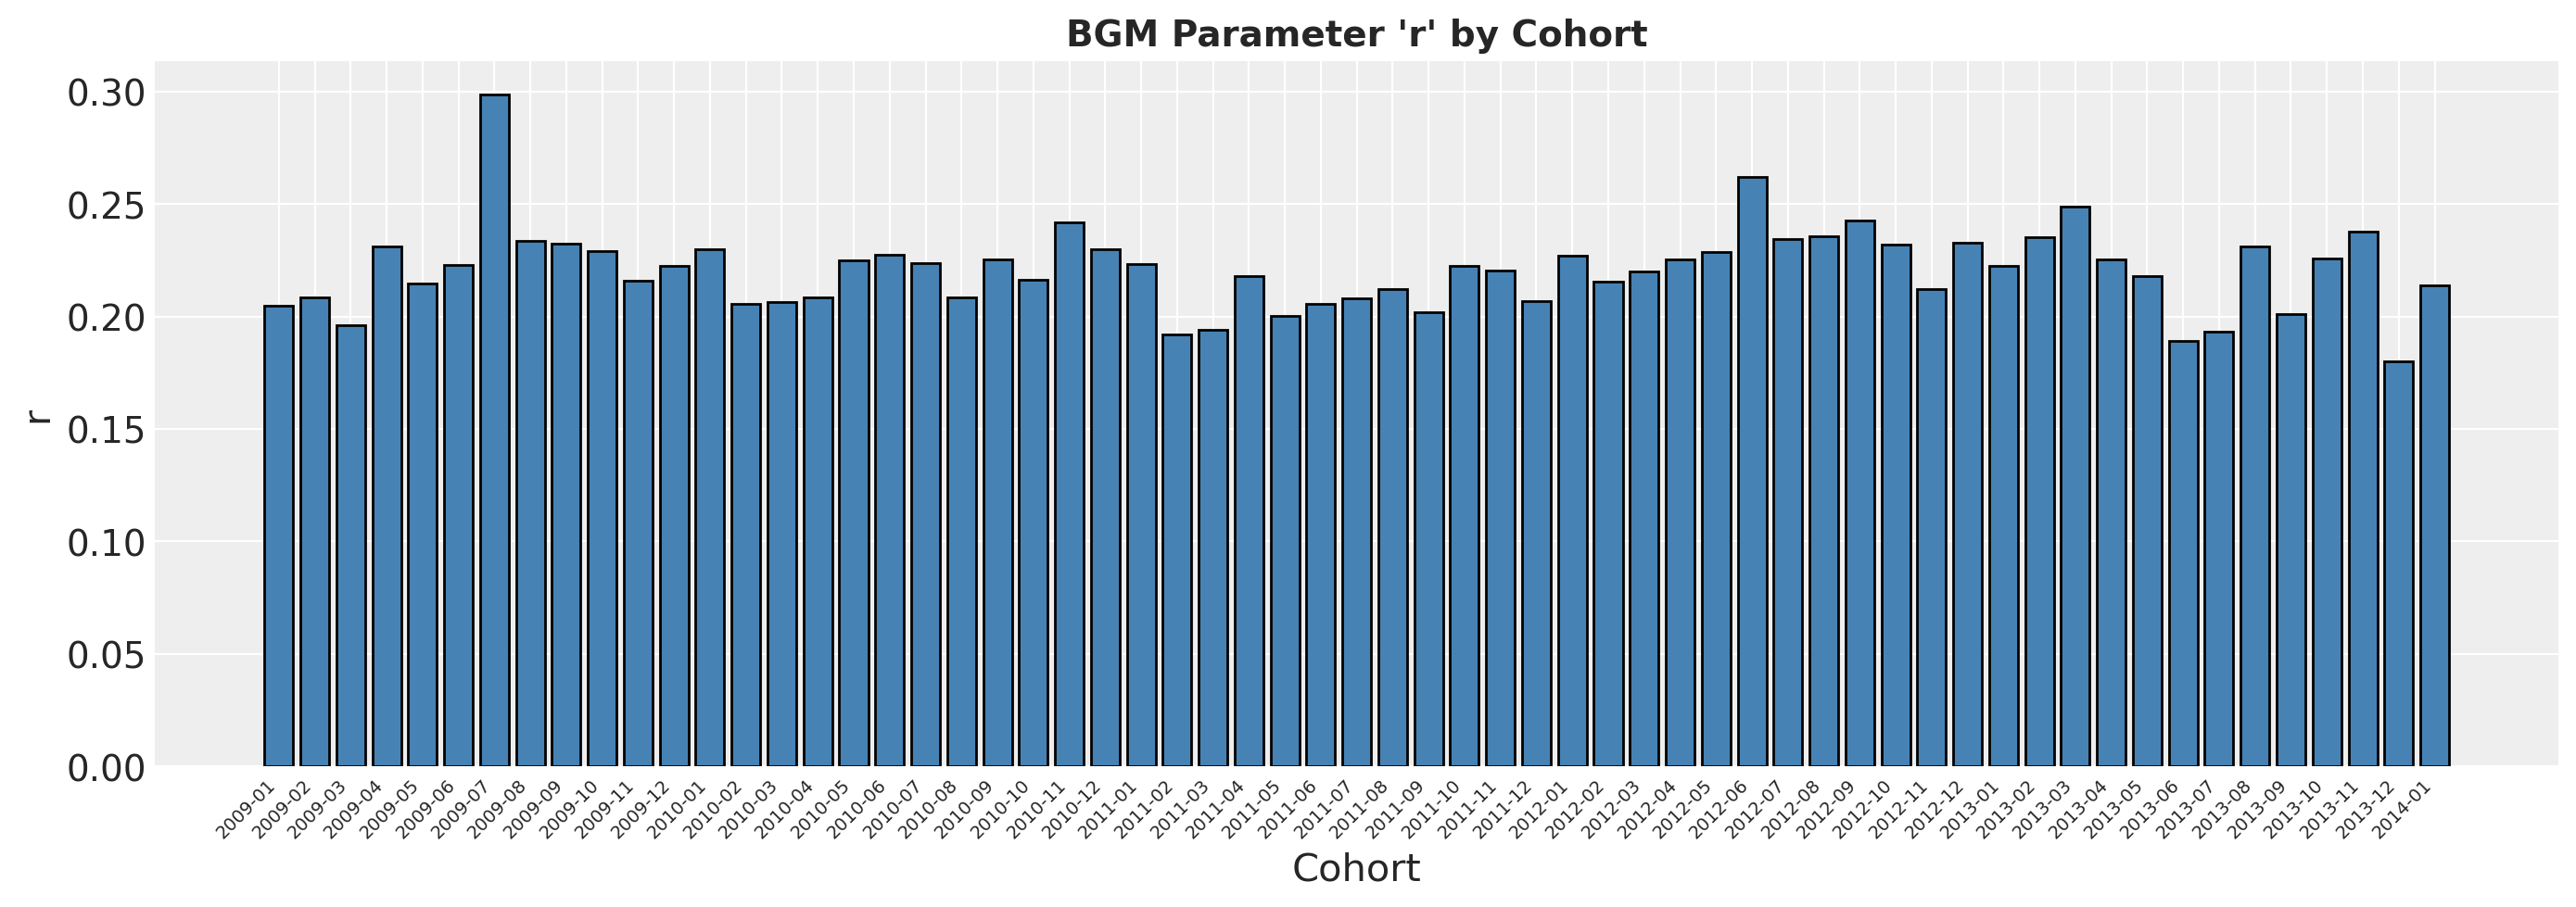

In [23]:
# BG/NBD parameter comparison
for param in ["a", "b", "alpha", "r"]:
    plot_cohort_parameter_comparison(cohort_results, param_name=param, model_type="bgm")
    plt.show()

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/2776794594.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


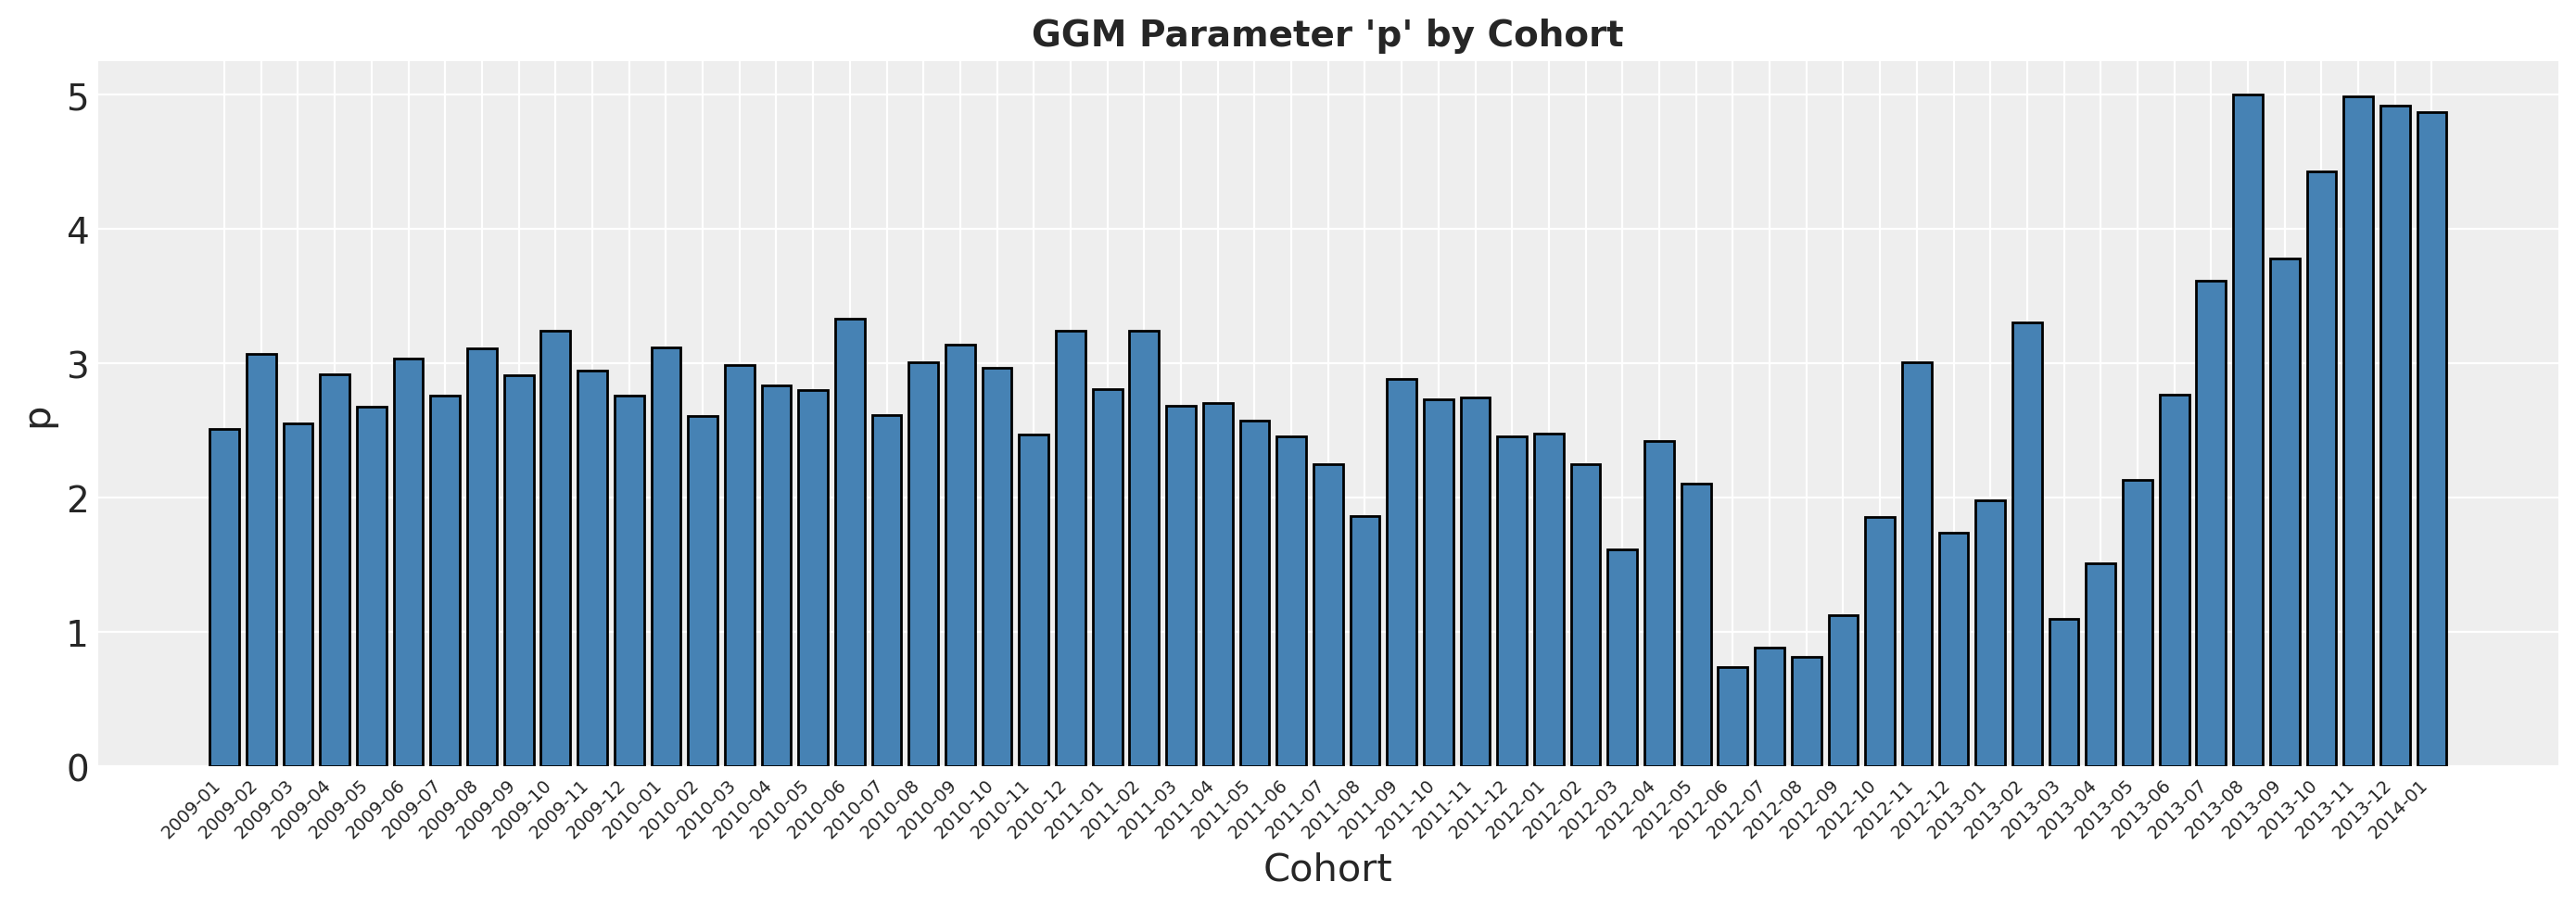

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/2776794594.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


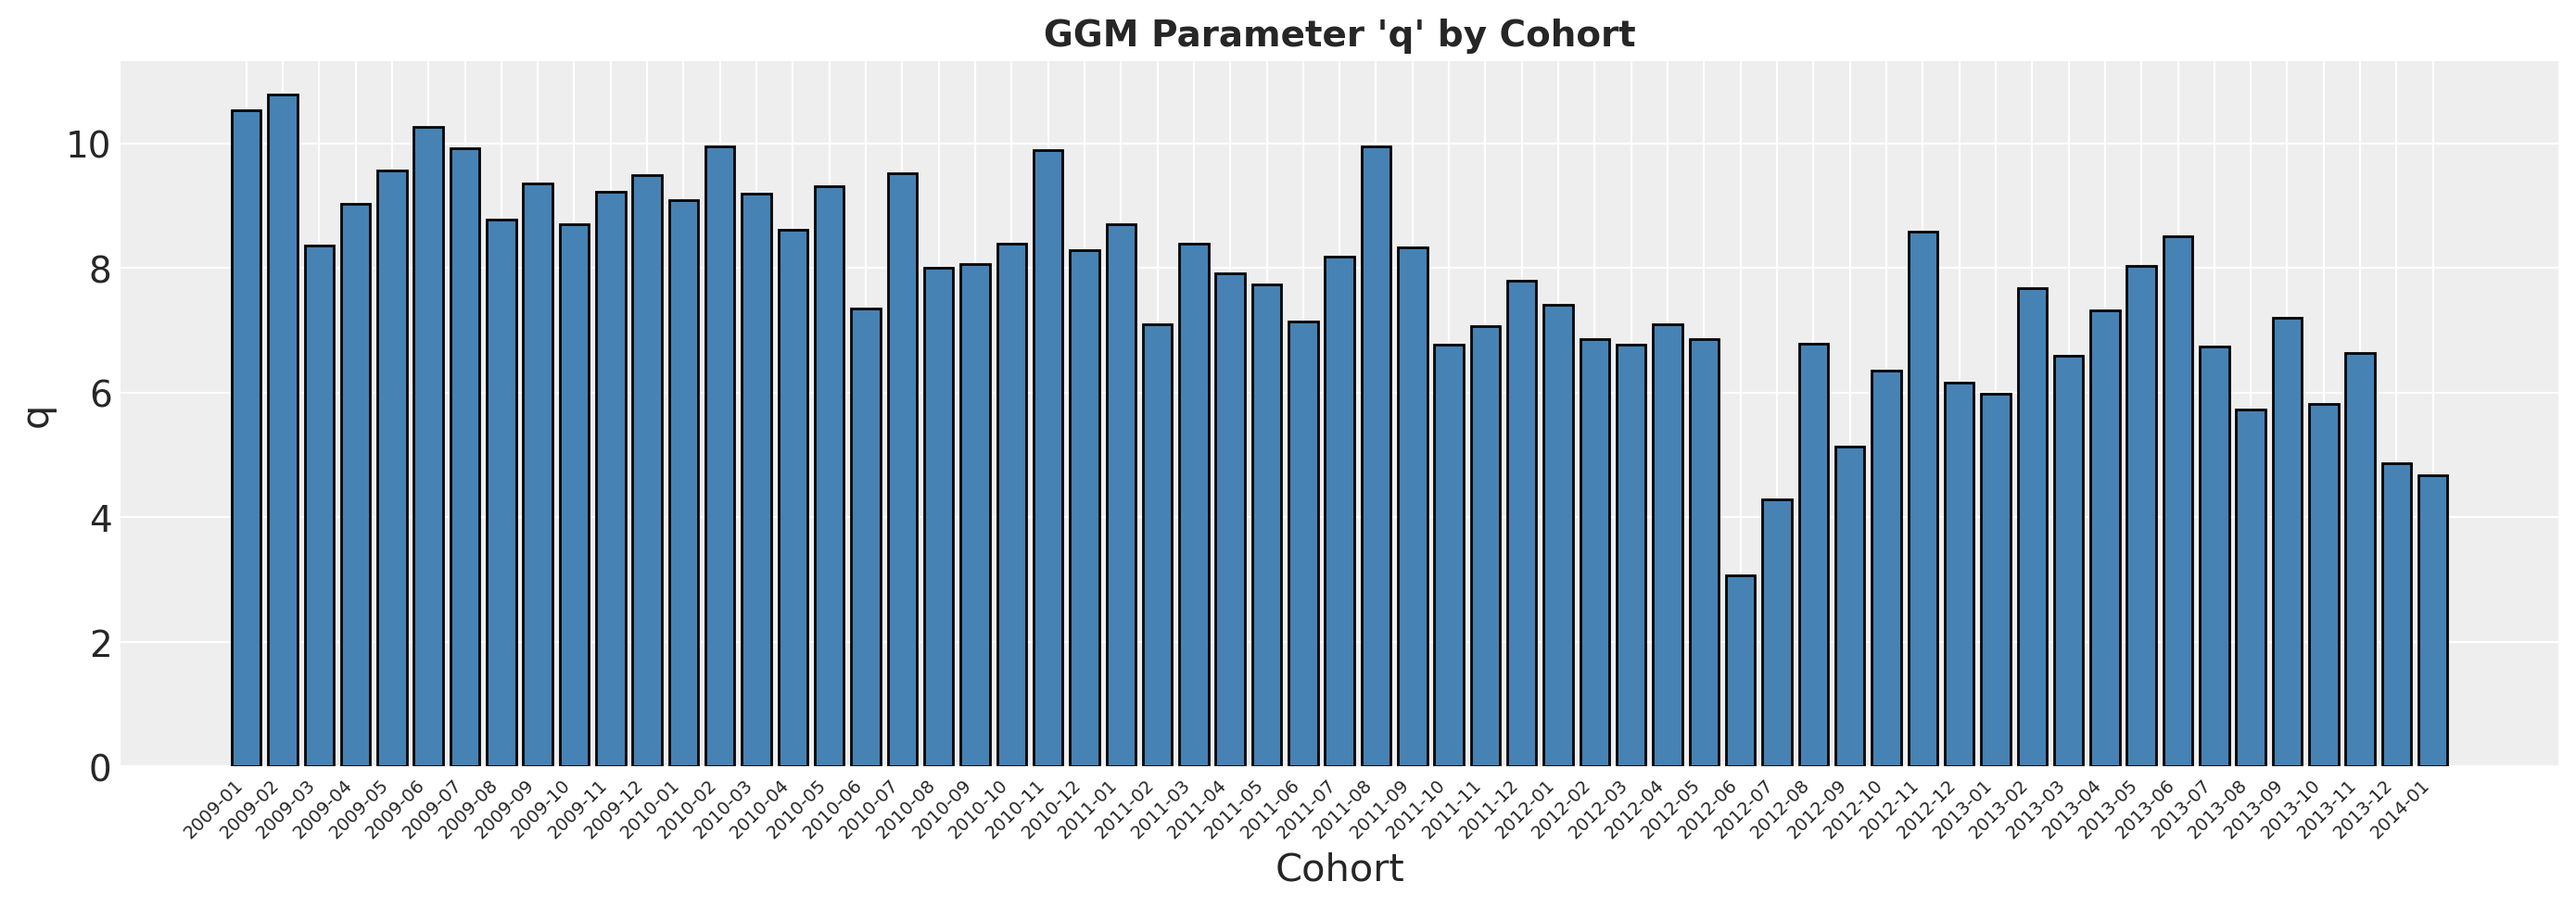

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/2776794594.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


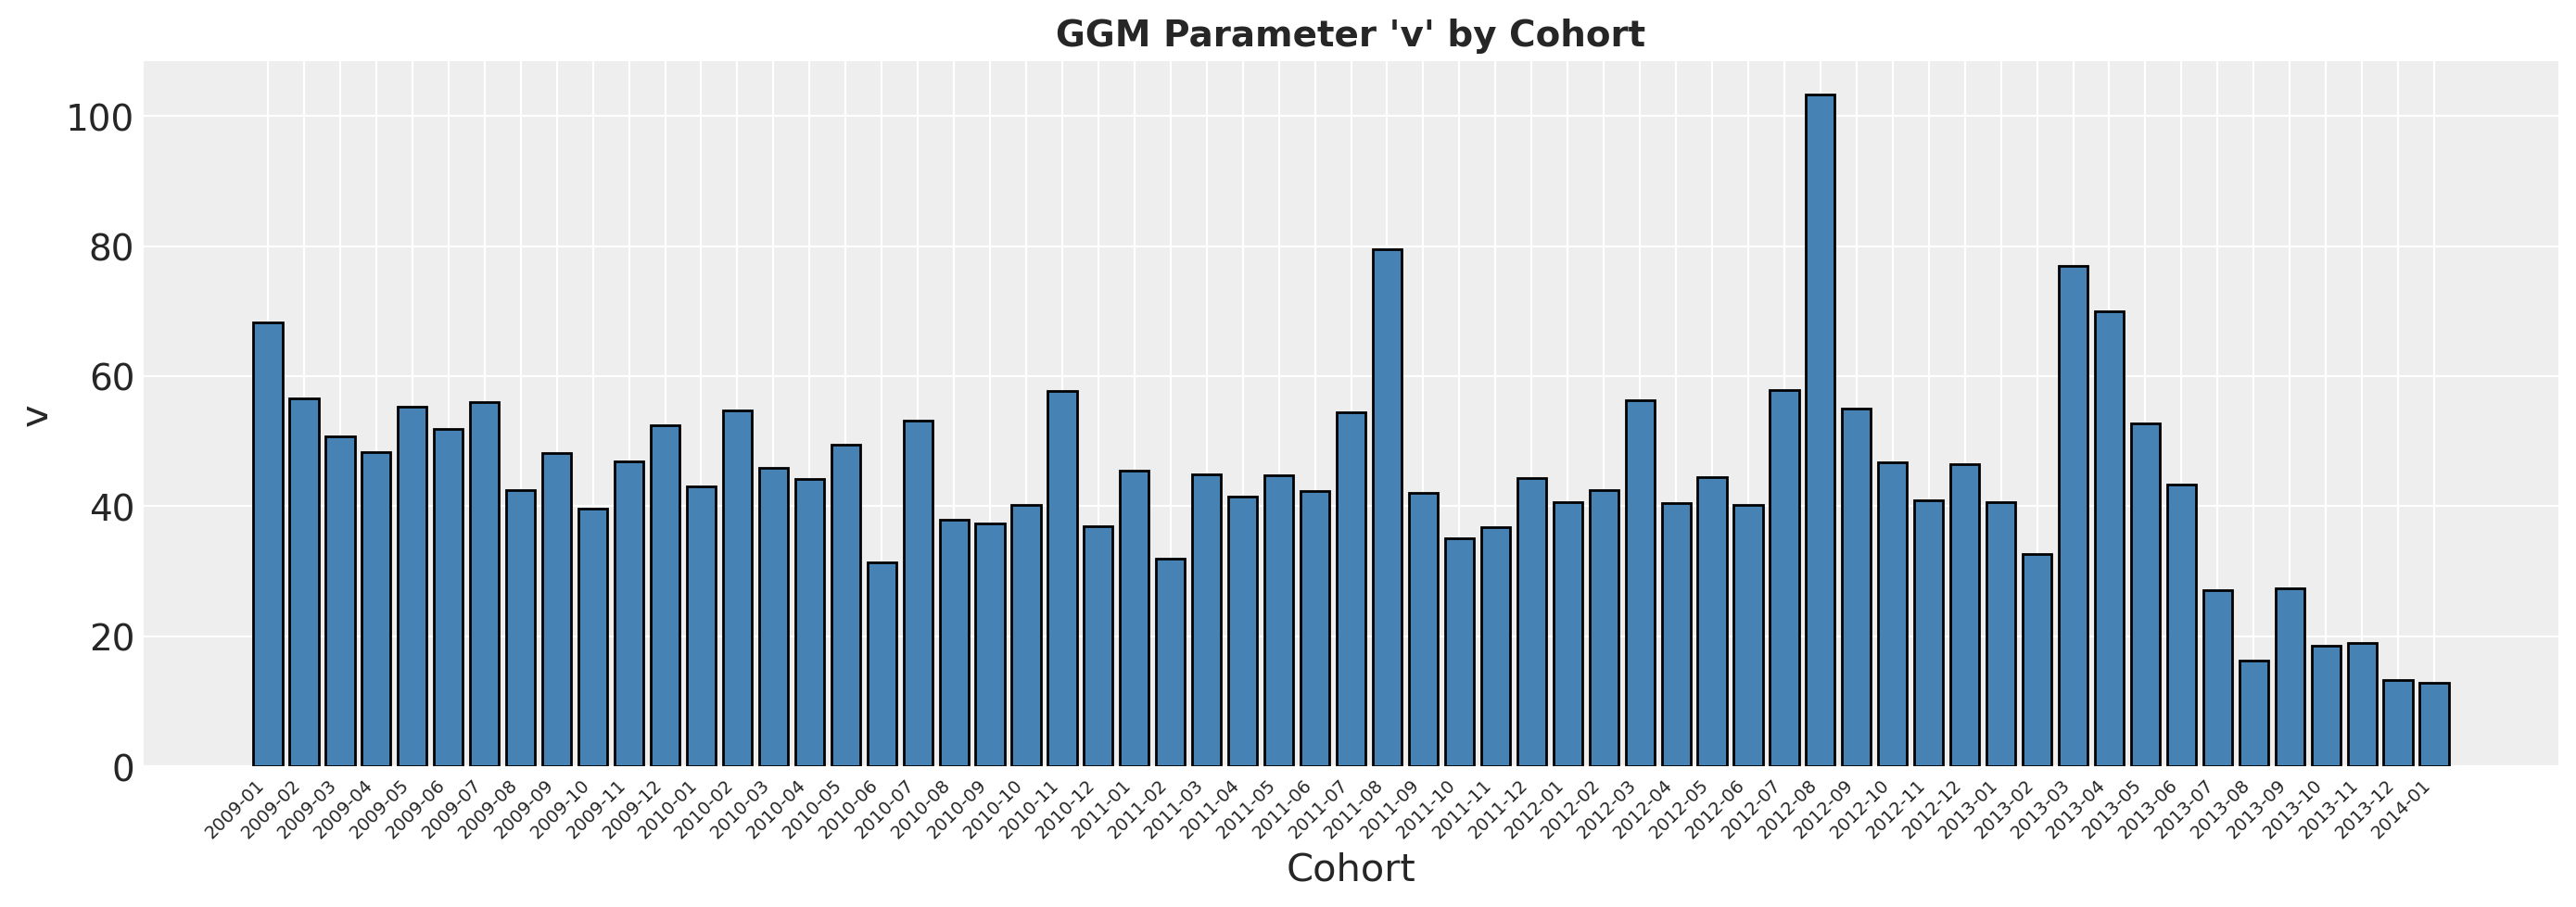

In [24]:
# Gamma-Gamma parameter comparison
for param in ["p", "q", "v"]:
    plot_cohort_parameter_comparison(cohort_results, param_name=param, model_type="ggm")
    plt.show()

---
## 9. Prediction Helper Functions

### Revenue prediction strategy

For each test month, we:
1. Compute **cumulative** expected purchases from `observation_end` to end of that month
   via `bgm.expected_purchases(future_t=days)`
2. Multiply by expected spend per purchase via `ggm.expected_customer_spend()`
3. Sum across customers to get cohort-level cumulative revenue
4. **Difference consecutive months** to get incremental monthly revenue

This cumulative-then-difference approach avoids double-counting.

In [25]:
def compute_cohort_monthly_revenue_predictions(
    cohort_result: dict[str, Any],
    test_periods: list[date],
    observation_end: date,
) -> xr.DataArray | None:
    """
    Compute monthly revenue predictions for a single cohort.

    Uses cumulative-to-incremental differencing:
    - Cumulative revenue at each period end = expected_purchases * expected_spend
    - Incremental monthly revenue = cumulative[i] - cumulative[i-1]

    Returns xr.DataArray with dims (chain, draw, period) or None.
    """
    bgm = cohort_result["bgm"]
    ggm = cohort_result["ggm"]
    rfm_pd = cohort_result["rfm_pd"]

    if bgm is None or ggm is None:
        return None

    # Expected spend per customer (from Gamma-Gamma, constant across periods)
    expected_spend = ggm.expected_customer_spend(data=rfm_pd)

    cumulative_revenues = []
    period_dates = []

    for period in test_periods:
        # End of current period = first day of next month
        if period.month == 12:
            next_month_start = date(period.year + 1, 1, 1)
        else:
            next_month_start = date(period.year, period.month + 1, 1)

        days_to_period_end = (next_month_start - observation_end).days

        if days_to_period_end <= 0:
            continue

        # Expected repeat purchases from observation_end to end of this month
        expected_purchases = bgm.expected_purchases(future_t=days_to_period_end)

        # Expected revenue = purchases * spend per purchase
        cumulative_revenue = expected_purchases * expected_spend

        # Clean Inf/NaN before summing
        cumulative_revenue_clean = cumulative_revenue.where(
            np.isfinite(cumulative_revenue), 0
        )

        # Sum across customers
        cohort_cumulative = cumulative_revenue_clean.sum("customer_id")

        cumulative_revenues.append(cohort_cumulative)
        period_dates.append(period)

    if not cumulative_revenues:
        return None

    # Convert cumulative to incremental monthly revenue
    monthly_revenues = []
    for i, (cum_rev, period) in enumerate(
        zip(cumulative_revenues, period_dates, strict=True)
    ):
        monthly_rev = cum_rev if i == 0 else cum_rev - cumulative_revenues[i - 1]
        monthly_revenues.append(monthly_rev.expand_dims({"period": [period]}))

    return xr.concat(monthly_revenues, dim="period")

In [26]:
def compute_monthly_revenue_predictions(
    cohort_results: dict[date, dict[str, Any]],
    periods: list[date],
    observation_end: date,
    *,
    verbose: bool = True,
) -> xr.DataArray:
    """
    Compute aggregate monthly revenue predictions across all cohorts.

    Returns xr.DataArray with dims (chain, draw, period).
    """
    if verbose:
        print(f"Computing monthly predictions for {len(periods)} periods...")

    all_cohort_predictions = []

    for _, result in cohort_results.items():
        preds = compute_cohort_monthly_revenue_predictions(
            cohort_result=result,
            test_periods=periods,
            observation_end=observation_end,
        )
        if preds is not None:
            all_cohort_predictions.append(preds)

    if not all_cohort_predictions:
        raise ValueError("No predictions computed for any cohort")

    # Sum across cohorts
    total = all_cohort_predictions[0]
    for pred in all_cohort_predictions[1:]:
        total = total + pred

    if verbose:
        print(f"  Aggregated predictions from {len(all_cohort_predictions)} cohorts")

    return total

In [27]:
def compute_actual_aggregate_revenue(
    transactions_df: pl.DataFrame,
    training_cohorts: list[date],
    data_start: date,
    data_end: date,
) -> pl.DataFrame:
    """
    Compute actual aggregate monthly revenue for training cohorts.

    Filters:
    - Only transactions from customers in training cohorts
    - Only repeat purchases (excludes acquisition month: period > cohort)

    Returns DataFrame with columns: month, revenue
    """
    return (
        transactions_df.filter(
            (pl.col("date") >= data_start) & (pl.col("date") < data_end)
        )
        .with_columns(pl.col("date").dt.truncate("1mo").alias("month"))
        .with_columns(
            pl.col("date").min().over("customer_id").dt.truncate("1mo").alias("cohort")
        )
        .filter(pl.col("cohort").is_in(training_cohorts))
        # Exclude acquisition month (only repeat revenue)
        .filter(pl.col("month") > pl.col("cohort"))
        .group_by("month")
        .agg(pl.col("value").sum().alias("revenue"))
        .sort("month")
    )

In [28]:
def compute_actual_revenue_by_cohort(
    transactions_df: pl.DataFrame,
    cohorts: list[date],
    data_start: date,
    data_end: date,
) -> pl.DataFrame:
    """
    Compute actual monthly revenue per cohort from transaction data.

    Excludes acquisition month (period > cohort).

    Returns DataFrame with columns: cohort, period, revenue
    """
    return (
        transactions_df.filter(
            (pl.col("date") >= data_start) & (pl.col("date") < data_end)
        )
        .with_columns(pl.col("date").dt.truncate("1mo").alias("period"))
        .with_columns(
            pl.col("date").min().over("customer_id").dt.truncate("1mo").alias("cohort")
        )
        .filter(pl.col("cohort").is_in(cohorts))
        # Exclude acquisition month
        .filter(pl.col("period") > pl.col("cohort"))
        .group_by(["cohort", "period"])
        .agg(pl.col("value").sum().alias("revenue"))
        .sort(["cohort", "period"])
    )

---
## 10. Predictions and Evaluation

In [29]:
# Generate test periods
test_periods: list[date] = []
current = PERIOD_TRAIN_TEST_SPLIT
while current < TEST_PERIOD_END:
    test_periods.append(current)
    if current.month == 12:
        current = date(current.year + 1, 1, 1)
    else:
        current = date(current.year, current.month + 1, 1)

print(f"Test periods ({len(test_periods)}):")
for p in test_periods:
    print(f"  {p}")

Test periods (15):
  2014-02-01
  2014-03-01
  2014-04-01
  2014-05-01
  2014-06-01
  2014-07-01
  2014-08-01
  2014-09-01
  2014-10-01
  2014-11-01
  2014-12-01
  2015-01-01
  2015-02-01
  2015-03-01
  2015-04-01


In [30]:
%%time

# Compute monthly revenue predictions for test period
test_predictions = compute_monthly_revenue_predictions(
    cohort_results=cohort_results,
    periods=test_periods,
    observation_end=PERIOD_TRAIN_TEST_SPLIT,
    verbose=True,
)

Computing monthly predictions for 15 periods...
  Aggregated predictions from 61 cohorts
CPU times: user 6.2 s, sys: 92.5 ms, total: 6.29 s
Wall time: 6.29 s


In [31]:
# Compute actual aggregate revenue (repeat purchases only, training cohorts only)
actual_revenue = compute_actual_aggregate_revenue(
    transactions_df=filtered_df,
    training_cohorts=list(cohort_results.keys()),
    data_start=DATA_START_DATE,
    data_end=TEST_PERIOD_END,
)

print(f"Actual revenue periods: {actual_revenue.height}")
actual_revenue

Actual revenue periods: 75


month,revenue
date,f64
2009-02-01,22798.47
2009-03-01,39462.69
2009-04-01,46881.14
2009-05-01,54400.36
2009-06-01,56928.07
…,…
2014-12-01,151643.85
2015-01-01,148305.31
2015-02-01,126925.64


In [32]:
# Extract predicted values for test periods
pred_periods = [
    pd.Timestamp(p).date() for p in test_predictions.coords["period"].to_numpy()
]

# MAP gives point estimates: shape (chain=1, draw=1, period)
pred_values = test_predictions.to_numpy().flatten()

# Build comparison DataFrame
pred_df = pl.DataFrame({"month": pred_periods, "predicted_revenue": pred_values})

comparison_df = (
    actual_revenue.filter(pl.col("month").is_in(pred_periods))
    .join(pred_df, on="month", how="inner")
    .with_columns(
        (pl.col("predicted_revenue") - pl.col("revenue")).alias("error"),
        (
            (pl.col("predicted_revenue") - pl.col("revenue")) / pl.col("revenue") * 100
        ).alias("pct_error"),
    )
    .sort("month")
)

print("Monthly Predicted vs Actual Revenue:")
comparison_df

Monthly Predicted vs Actual Revenue:


month,revenue,predicted_revenue,error,pct_error
date,f64,f64,f64,f64
2014-02-01,201170.79,184062.055457,-17108.734543,-8.504582
2014-03-01,205782.03,188412.132444,-17369.897556,-8.44092
2014-04-01,197584.88,173404.713585,-24180.166415,-12.237863
2014-05-01,186597.59,172335.712246,-14261.877754,-7.64312
2014-06-01,174262.89,161367.255321,-12895.634679,-7.400104
…,…,…,…,…
2014-12-01,151643.85,144532.371269,-7111.478731,-4.689593
2015-01-01,148305.31,141795.264071,-6510.045929,-4.389624
2015-02-01,126925.64,125868.821633,-1056.818367,-0.832628


In [33]:
# Compute summary metrics
actual_vals = comparison_df["revenue"].to_numpy()
pred_vals = comparison_df["predicted_revenue"].to_numpy()

mae = np.mean(np.abs(actual_vals - pred_vals))
rmse = np.sqrt(np.mean((actual_vals - pred_vals) ** 2))
mape = np.mean(np.abs((actual_vals - pred_vals) / actual_vals)) * 100

total_actual = actual_vals.sum()
total_predicted = pred_vals.sum()
total_pct_error = (total_predicted - total_actual) / total_actual * 100

print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.1f}%")
print(f"\nTotal actual revenue (test):    {total_actual:,.2f}")
print(f"Total predicted revenue (test): {total_predicted:,.2f}")
print(f"Total prediction error:         {total_pct_error:+.1f}%")
print("=" * 60)

EVALUATION METRICS
MAE:  12,158.96
RMSE: 14,304.19
MAPE: 7.7%

Total actual revenue (test):    2,427,667.64
Total predicted revenue (test): 2,321,211.35
Total prediction error:         -4.4%


---
## 11. Visualizations

### Aggregate Revenue Over Time

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/586422258.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


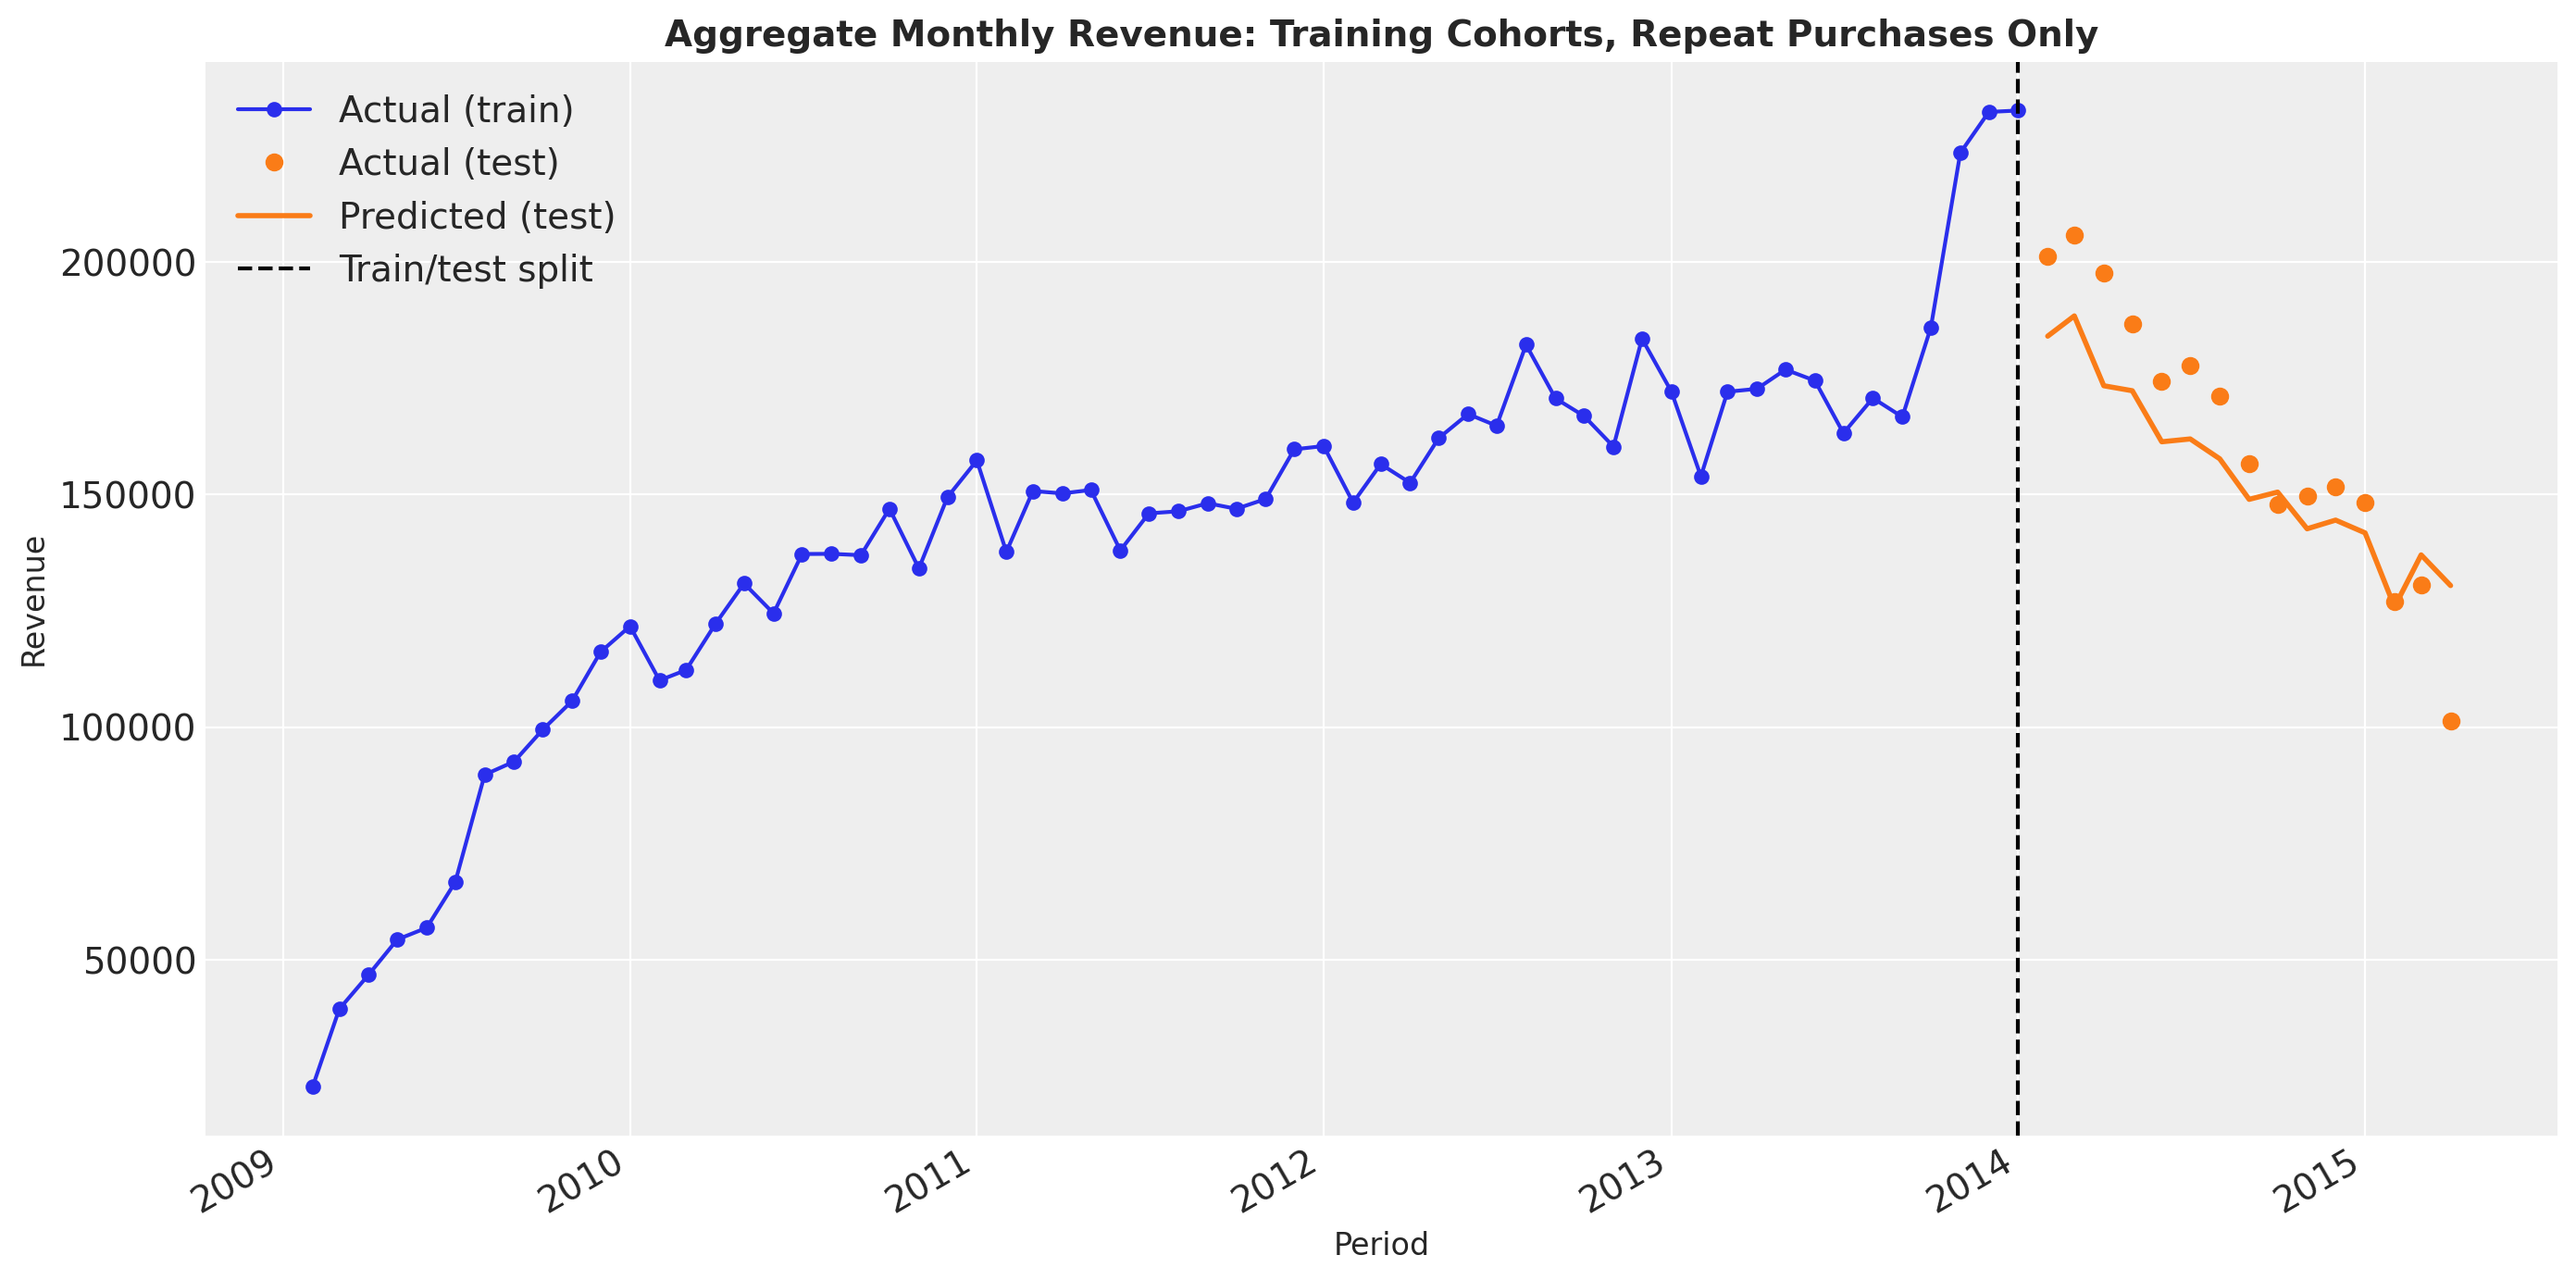

In [34]:
fig, ax = plt.subplots(figsize=(14, 7))

# Actual revenue (train + test)
actual_months = actual_revenue["month"].to_list()
actual_values = actual_revenue["revenue"].to_list()

# Split into train and test actuals
train_months = [m for m in actual_months if m < PERIOD_TRAIN_TEST_SPLIT]
train_values = [
    v
    for m, v in zip(actual_months, actual_values, strict=True)
    if m < PERIOD_TRAIN_TEST_SPLIT
]
test_months_actual = [m for m in actual_months if m >= PERIOD_TRAIN_TEST_SPLIT]
test_values_actual = [
    v
    for m, v in zip(actual_months, actual_values, strict=True)
    if m >= PERIOD_TRAIN_TEST_SPLIT
]

ax.plot(
    train_months,
    train_values,
    "o-",
    color="C0",
    linewidth=1.5,
    markersize=5,
    label="Actual (train)",
)
ax.plot(
    test_months_actual,
    test_values_actual,
    "o",
    color="C1",
    markersize=6,
    label="Actual (test)",
)

# Predicted test revenue
ax.plot(
    pred_periods,
    pred_values,
    "-",
    color="C1",
    linewidth=2,
    label="Predicted (test)",
)

ax.axvline(
    PERIOD_TRAIN_TEST_SPLIT - pd.DateOffset(months=1),
    color="black",
    linestyle="--",
    linewidth=1.5,
    label="Train/test split",
)

ax.set_xlabel("Period", fontsize=12)
ax.set_ylabel("Revenue", fontsize=12)
ax.set_title(
    "Aggregate Monthly Revenue: Training Cohorts, Repeat Purchases Only",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="upper left")
fig.autofmt_xdate()
plt.tight_layout()

### Per-Cohort Revenue Predictions

In [54]:
def plot_cohort_revenue_predictions(
    cohort_results: dict[date, dict[str, Any]],
    transactions_df: pl.DataFrame,
    cohorts_to_plot: list[date],
    train_test_split: date,
    test_end: date,
    data_start: date,
    figsize: tuple[int, int] = (15, 21),
) -> plt.Figure:
    """Create faceted revenue prediction plots per cohort."""
    n_cohorts = len(cohorts_to_plot)
    if n_cohorts == 0:
        raise ValueError("No cohorts to plot")

    # Generate test periods
    test_periods = []
    current = train_test_split
    while current < test_end:
        test_periods.append(current)
        if current.month == 12:
            current = date(current.year + 1, 1, 1)
        else:
            current = date(current.year, current.month + 1, 1)

    # Compute actual revenue by cohort
    actual_revenue = compute_actual_revenue_by_cohort(
        transactions_df=transactions_df,
        cohorts=cohorts_to_plot,
        data_start=data_start,
        data_end=test_end,
    )

    fig, axes = plt.subplots(
        nrows=n_cohorts,
        ncols=1,
        figsize=figsize,
        sharex=True,
        sharey=False,
        layout="constrained",
    )
    if n_cohorts == 1:
        axes = [axes]

    for cohort_id, ax in zip(cohorts_to_plot, axes, strict=True):
        cohort_name = cohort_id.isoformat()

        cohort_actual = actual_revenue.filter(pl.col("cohort") == cohort_id)

        # Training actual
        train_actual = cohort_actual.filter(pl.col("period") < train_test_split)
        if train_actual.height > 0:
            ax.plot(
                train_actual["period"].to_list(),
                train_actual["revenue"].to_list(),
                "o-",
                color="C0",
                linewidth=1.5,
                markersize=5,
                label="observed revenue (train)",
            )

        # Test actual
        test_actual = cohort_actual.filter(pl.col("period") >= train_test_split)

        # Predictions
        predictions = None
        if cohort_id in cohort_results:
            result = cohort_results[cohort_id]
            predictions = compute_cohort_monthly_revenue_predictions(
                cohort_result=result,
                test_periods=test_periods,
                observation_end=train_test_split,
            )

        if predictions is not None:
            pred_periods_cohort = [
                pd.Timestamp(p).date() for p in predictions.coords["period"].to_numpy()
            ]
            means = predictions.to_numpy().flatten()
            means = np.where(np.isfinite(means), means, np.nan)

            ax.plot(
                pred_periods_cohort,
                means,
                linestyle="-",
                marker="o",
                markersize=5,
                color="C1",
                linewidth=2,
                label="prediction",
            )

        if test_actual.height > 0:
            ax.plot(
                test_actual["period"].to_list(),
                test_actual["revenue"].to_list(),
                marker="o",
                linestyle="-",
                color="black",
                markersize=5,
                label="observed revenue (test)",
            )

        ax.axvline(
            train_test_split - pd.DateOffset(months=1),
            color="black",
            linestyle="--",
            linewidth=1.5,
            label="train/pred split",
        )

        ax.set_ylabel("Revenue")
        ax.set_title(f"Revenue - Cohort {cohort_name}")
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    axes[-1].set_xlabel("period")
    fig.autofmt_xdate()
    fig.suptitle(
        "Revenue Predictions by Cohort", y=1.03, fontsize=20, fontweight="bold"
    )

    return fig

In [57]:
# Select representative cohorts to plot
available_cohorts = sorted(cohort_results.keys())
n_available = len(available_cohorts)

# Pick ~8 cohorts spanning early, middle, and late
if n_available >= 8:
    indices = [0, 10, 20, 30, 40, 50, 55, 59]
    cohorts_to_plot = [available_cohorts[i] for i in indices]
else:
    cohorts_to_plot = available_cohorts

print(
    f"Plotting {len(cohorts_to_plot)} cohorts: {[c.isoformat() for c in cohorts_to_plot]}"  # noqa: E501
)

Plotting 8 cohorts: ['2009-01-01', '2009-11-01', '2010-09-01', '2011-07-01', '2012-05-01', '2013-03-01', '2013-08-01', '2013-12-01']


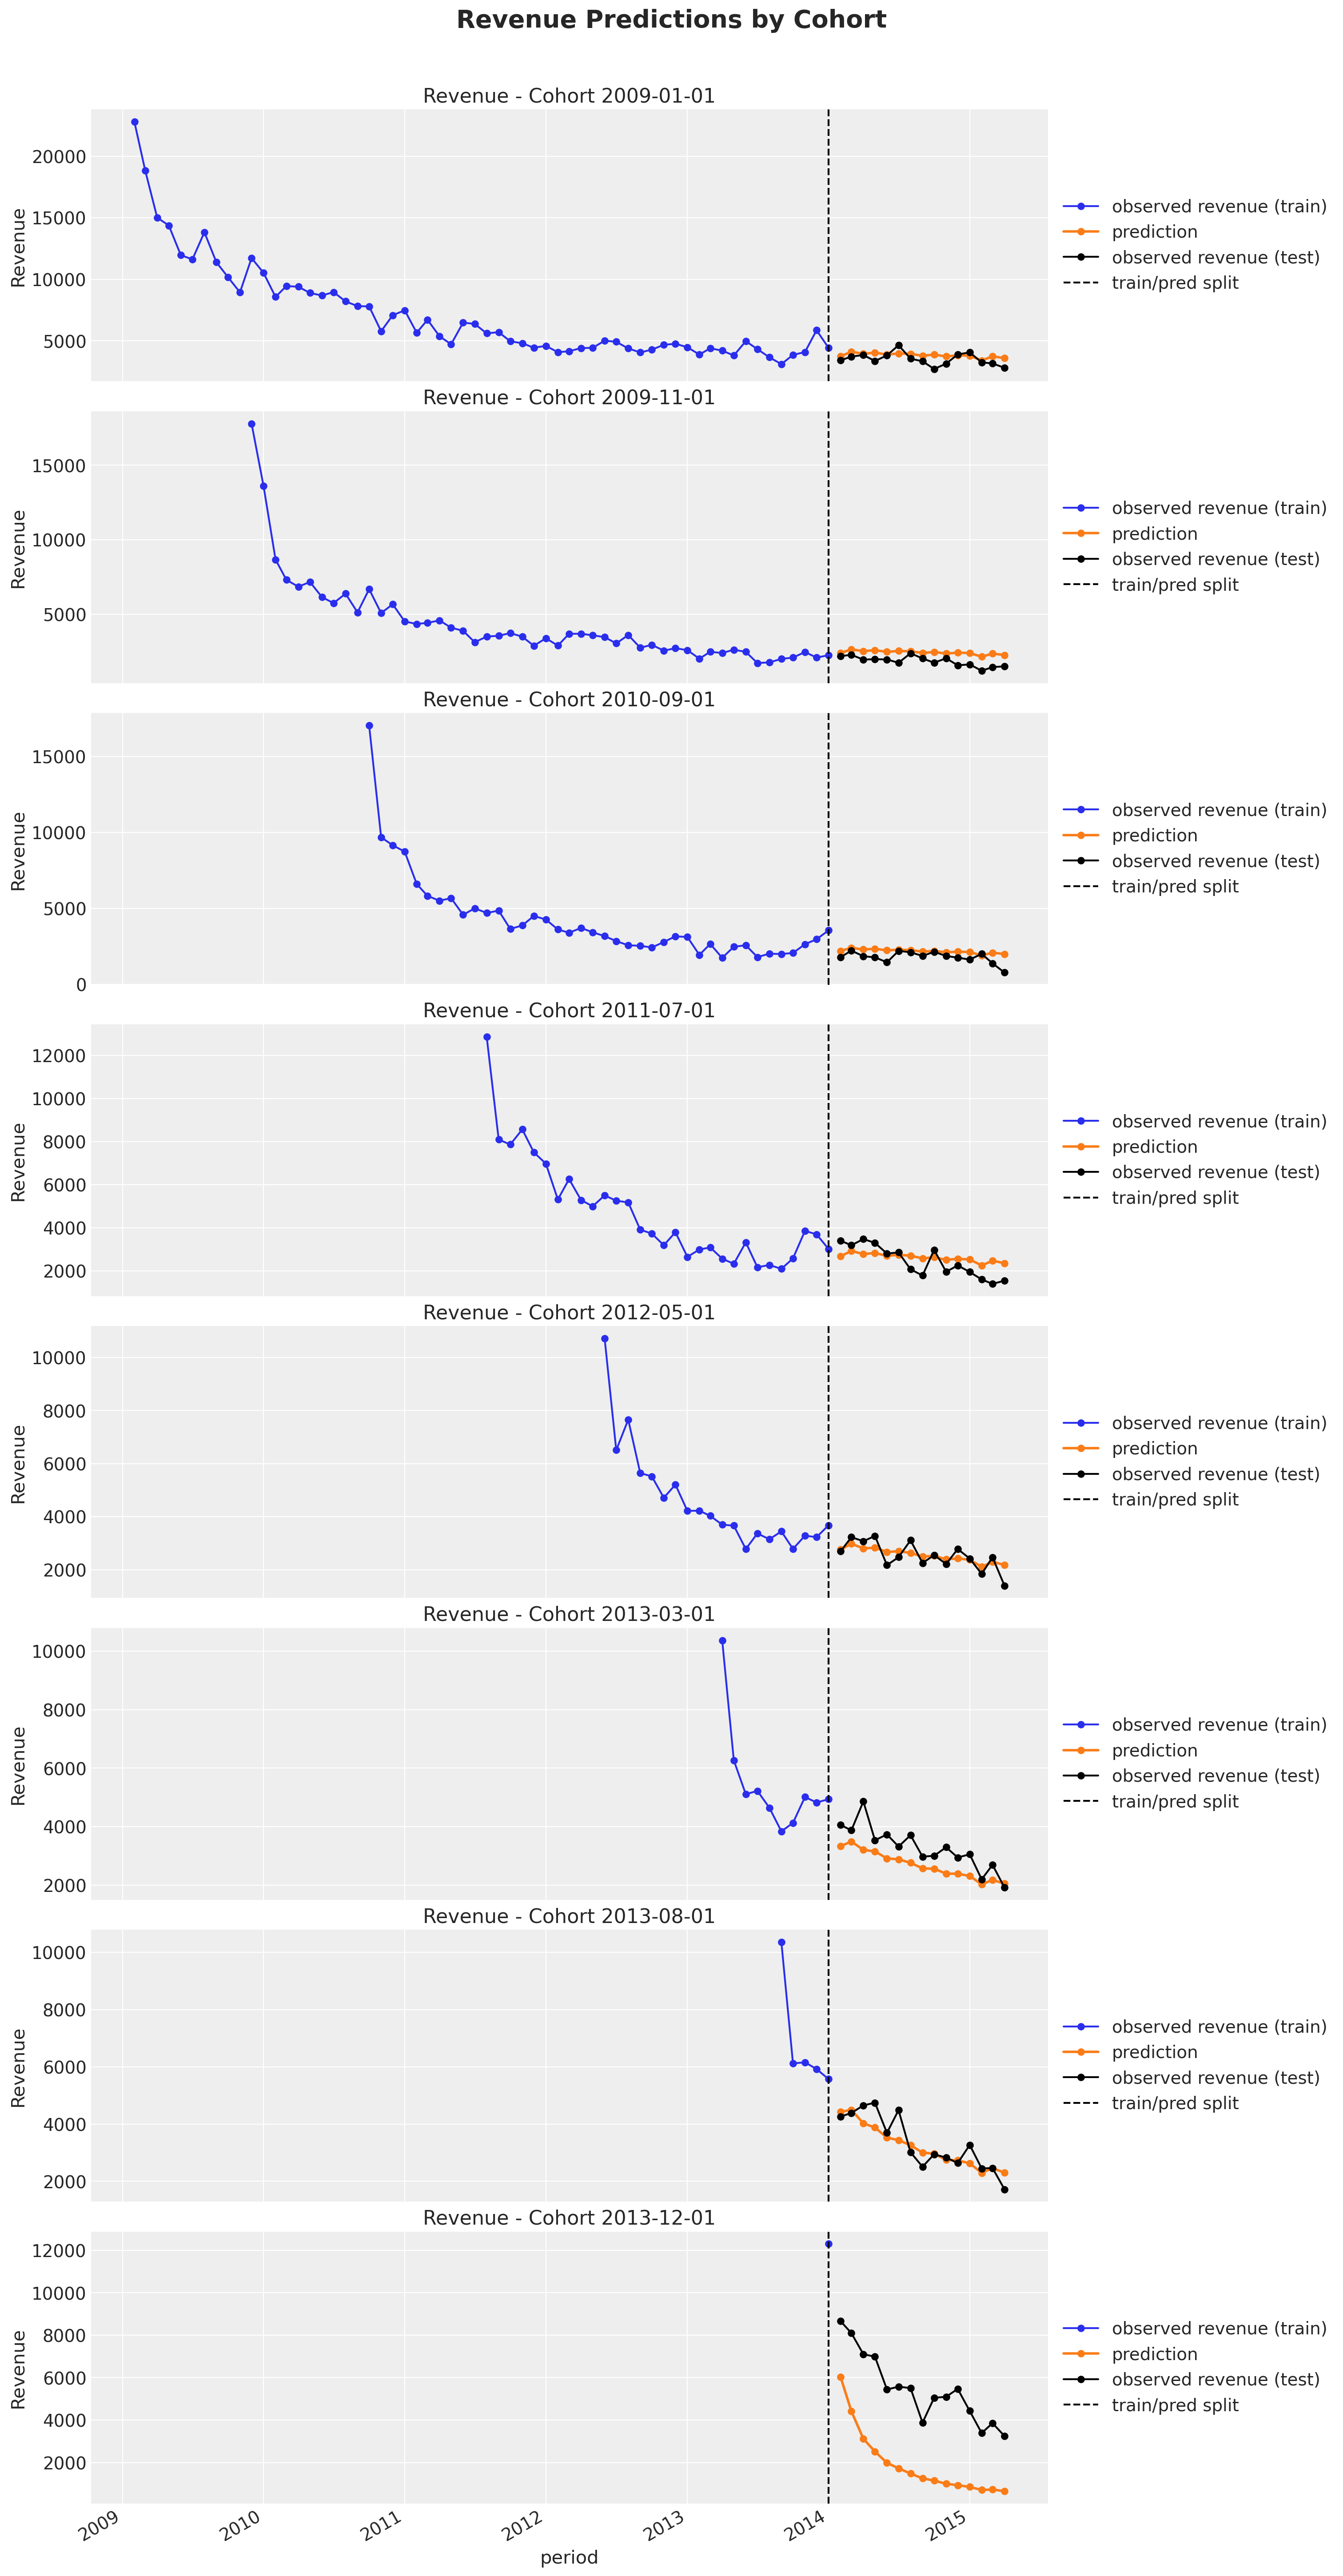

In [58]:
plot_cohort_revenue_predictions(
    cohort_results=cohort_results,
    transactions_df=filtered_df,
    cohorts_to_plot=cohorts_to_plot,
    train_test_split=PERIOD_TRAIN_TEST_SPLIT,
    test_end=TEST_PERIOD_END,
    data_start=DATA_START_DATE,
    figsize=(15, 3.5 * len(cohorts_to_plot)),
)
plt.show()

### Predicted vs Actual Total Revenue

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_18537/4080214089.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


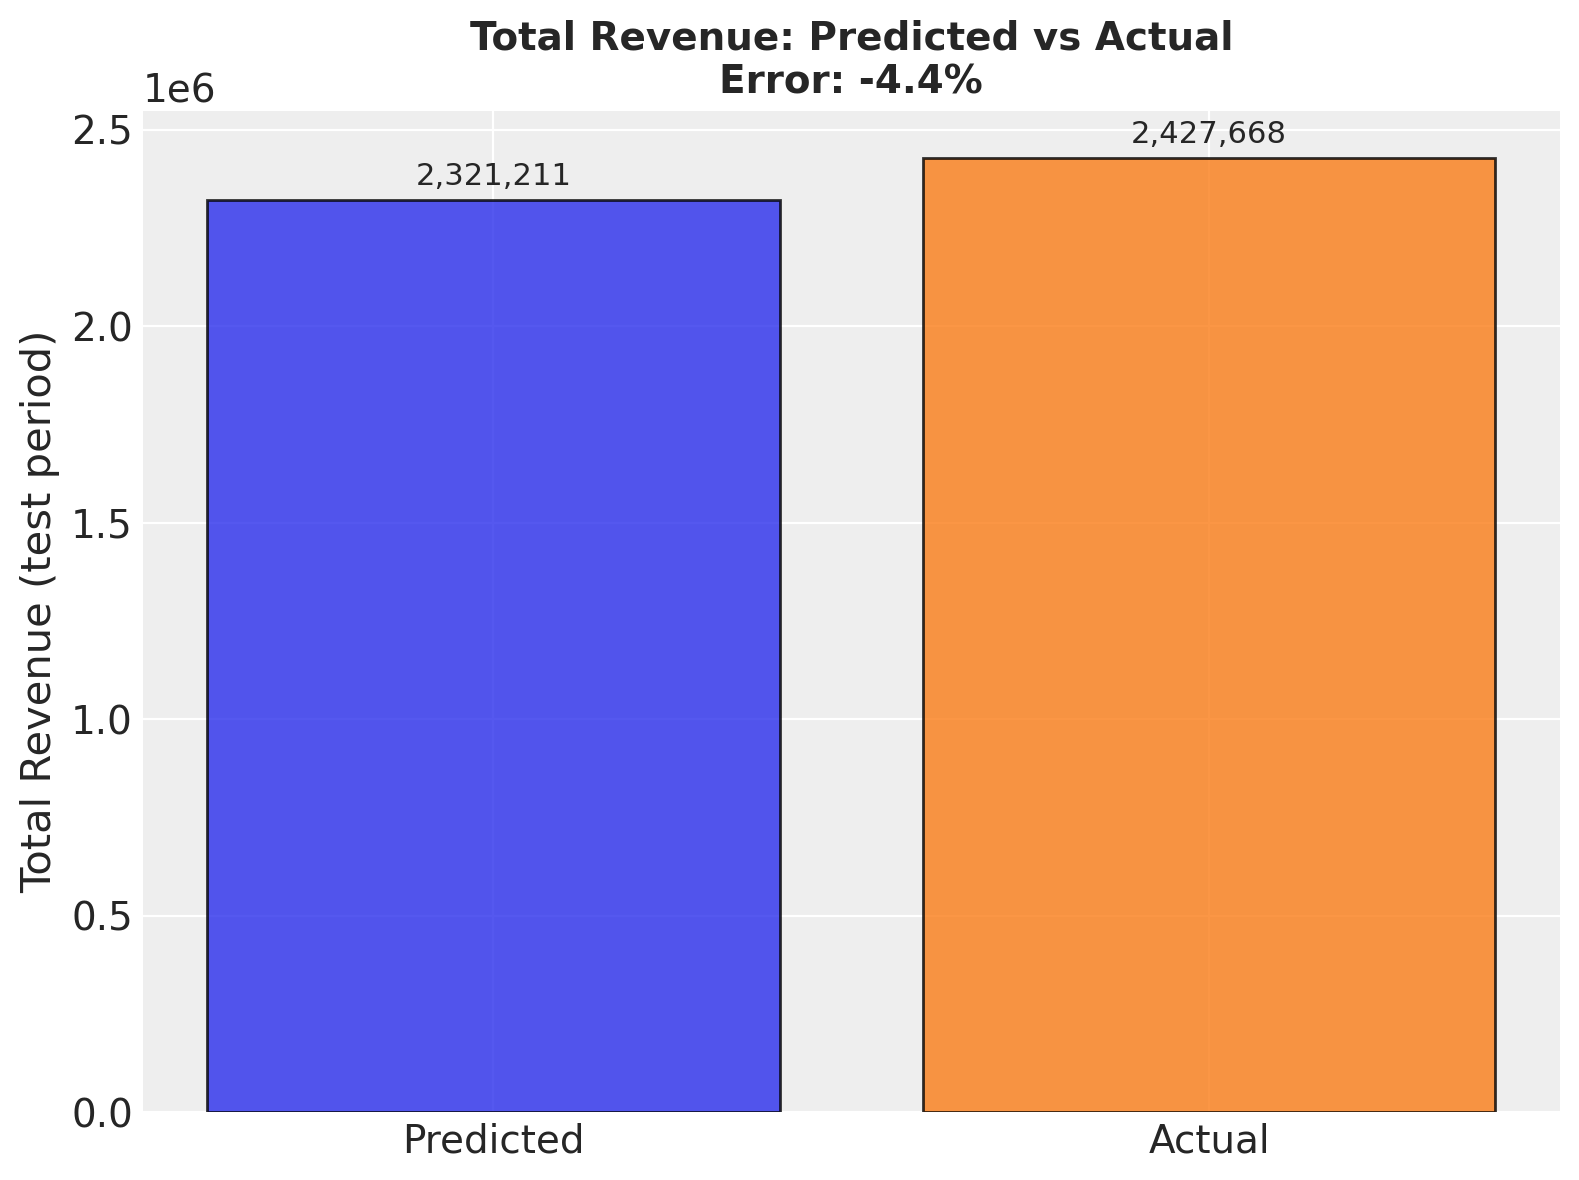

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(
    [0, 1],
    [total_predicted, total_actual],
    color=["C0", "C1"],
    alpha=0.8,
    edgecolor="black",
)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Predicted", "Actual"])
ax.set_ylabel("Total Revenue (test period)")
ax.set_title(
    f"Total Revenue: Predicted vs Actual\nError: {total_pct_error:+.1f}%",
    fontsize=14,
    fontweight="bold",
)

# Add value labels on bars
for bar, val in zip(bars, [total_predicted, total_actual], strict=True):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 1.01,
        f"{val:,.0f}",
        ha="center",
        va="bottom",
        fontsize=11,
    )

plt.tight_layout()

In [39]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, model_name: str) -> dict:
    """Compute evaluation metrics for a model."""
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        "Model": model_name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2),
    }


metrics_list = [
    compute_metrics(actual_vals, pred_vals, "PyMC-Marketing (BG/NBD + Gamma-Gamma)"),
]

metrics_df = pd.DataFrame(metrics_list)
metrics_df

,Model,MAE,RMSE,MAPE (%)
0,PyMC-Marketing (BG/NBD + Gamma-Gamma),12158.96,14304.19,7.71


---
## 12. Watermark

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu, 19 Feb 2026

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.10.0

arviz         : 0.23.1
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
polars        : 1.37.1
pymc_extras   : 0.7.0
pymc_marketing: 0.17.1
xarray        : 2026.1.0

Watermark: 2.6.0

